<a href="https://colab.research.google.com/github/LS-SDU/ip-tracker/blob/main/nlp%EF%BC%88minimind%EF%BC%89%E5%AE%9E%E9%AA%8C%E4%BA%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title 1. 环境准备与依赖安装
!git clone https://github.com/jingyaogong/minimind.git
%cd minimind
!pip install -r requirements.txt -i https://mirrors.aliyun.com/pypi/simple

# 挂载 Google Drive (如果需要保存模型到云端硬盘)
from google.colab import drive
import os
try:
    drive.mount('/content/drive')
    # 创建实验保存目录
    save_dir = '/content/drive/MyDrive/NLP_Experiment_MiniMind'
    os.makedirs(save_dir, exist_ok=True)
    print(f"模型将保存到: {save_dir}")
except:
    print("Google Drive 挂载失败或跳过，模型将保存在本地临时目录。")
    save_dir = './out'
    os.makedirs(save_dir, exist_ok=True)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import math
import json
import random
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, PreTrainedTokenizerFast

# 设置随机种子
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

setup_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

fatal: destination path 'minimind' already exists and is not an empty directory.
/content/minimind
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
模型将保存到: /content/drive/MyDrive/NLP_Experiment_MiniMind


/usr/local/lib/python3.12/dist-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


Using device: cuda


In [ ]:
# @title 2. 模型核心模块定义 (RMSNorm, RoPE, MiniMindLM)

# --- 配置类 ---
class LMConfig:
    def __init__(self, dim=512, n_layers=8, n_heads=8, max_seq_len=512, vocab_size=64000):
        self.dim = dim
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.max_seq_len = max_seq_len
        self.vocab_size = vocab_size
        self.multiple_of = 256
        self.ffn_dim_multiplier = None
        self.norm_eps = 1e-5
        self.rope_theta = 10000.0
        self.dropout = 0.0
        self.use_moe = False

# --- 模块 1: RMSNorm (分析重点) ---
class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def forward(self, x):
        # 1. 计算均方根 (RMS): sqrt(mean(x^2))
        var = x.pow(2).mean(-1, keepdim=True)
        x_normed = x * torch.rsqrt(var + self.eps)
        # 2. 缩放
        return self.weight * x_normed

# --- 模块 2: RoPE 旋转位置编码 (分析重点) ---
def precompute_pos_cis(dim: int, end: int, theta: float = 10000.0):
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
    t = torch.arange(end, device=freqs.device)
    freqs = torch.outer(t, freqs).float()
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # complex64
    return freqs_cis

def apply_rotary_emb(xq, xk, freqs_cis):
    # 将 query 和 key 转换为复数形式进行旋转
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    freqs_cis = freqs_cis[:xq_.shape[1], :].unsqueeze(0).unsqueeze(0) # 广播维度

    # 旋转操作: complex_vector * complex_rotor
    xq_out = torch.view_as_real(xq_ * freqs_cis).flatten(3)
    xk_out = torch.view_as_real(xk_ * freqs_cis).flatten(3)
    return xq_out.type_as(xq), xk_out.type_as(xk)

# --- Attention & FeedForward ---
class Attention(nn.Module):
    def __init__(self, args: LMConfig):
        super().__init__()
        self.n_heads = args.n_heads
        self.head_dim = args.dim // args.n_heads
        self.wq = nn.Linear(args.dim, args.n_heads * self.head_dim, bias=False)
        self.wk = nn.Linear(args.dim, args.n_heads * self.head_dim, bias=False)
        self.wv = nn.Linear(args.dim, args.n_heads * self.head_dim, bias=False)
        self.wo = nn.Linear(args.n_heads * self.head_dim, args.dim, bias=False)

    def forward(self, x, freqs_cis, mask=None):
        bsz, seqlen, _ = x.shape
        xq, xk, xv = self.wq(x), self.wk(x), self.wv(x)

        xq = xq.view(bsz, seqlen, self.n_heads, self.head_dim)
        xk = xk.view(bsz, seqlen, self.n_heads, self.head_dim)
        xv = xv.view(bsz, seqlen, self.n_heads, self.head_dim)

        xq, xk = apply_rotary_emb(xq, xk, freqs_cis)

        # Flash Attention 这里的简化实现
        scores = torch.matmul(xq, xk.transpose(2, 3)) / math.sqrt(self.head_dim)
        if mask is not None:
            scores = scores + mask
        scores = F.softmax(scores.float(), dim=-1).type_as(xq)
        output = torch.matmul(scores, xv)

        output = output.transpose(1, 2).contiguous().view(bsz, seqlen, -1)
        return self.wo(output)

class FeedForward(nn.Module):
    def __init__(self, args: LMConfig):
        super().__init__()
        hidden_dim = 4 * args.dim
        hidden_dim = int(2 * hidden_dim / 3)
        self.w1 = nn.Linear(args.dim, hidden_dim, bias=False)
        self.w2 = nn.Linear(hidden_dim, args.dim, bias=False)
        self.w3 = nn.Linear(args.dim, hidden_dim, bias=False)

    def forward(self, x):
        return self.w2(F.silu(self.w1(x)) * self.w3(x))

class TransformerBlock(nn.Module):
    def __init__(self, args: LMConfig):
        super().__init__()
        self.attention = Attention(args)
        self.feed_forward = FeedForward(args)
        self.attention_norm = RMSNorm(args.dim, eps=args.norm_eps)
        self.ffn_norm = RMSNorm(args.dim, eps=args.norm_eps)

    def forward(self, x, freqs_cis, mask):
        h = x + self.attention(self.attention_norm(x), freqs_cis, mask)
        out = h + self.feed_forward(self.ffn_norm(h))
        return out

# --- 主模型 MiniMindLM ---
class MiniMindLM(nn.Module):
    def __init__(self, params: LMConfig):
        super().__init__()
        self.params = params
        self.tok_embeddings = nn.Embedding(params.vocab_size, params.dim)
        self.layers = nn.ModuleList([TransformerBlock(params) for _ in range(params.n_layers)])
        self.norm = RMSNorm(params.dim, eps=params.norm_eps)
        self.output = nn.Linear(params.dim, params.vocab_size, bias=False)
        self.freqs_cis = precompute_pos_cis(self.params.dim // self.params.n_heads, self.params.max_seq_len * 2).to(device)

        # 权重绑定 (Weight Tying)
        self.tok_embeddings.weight = self.output.weight

    def forward(self, tokens):
        _bsz, seqlen = tokens.shape
        h = self.tok_embeddings(tokens)
        freqs_cis = self.freqs_cis[:seqlen]

        # Causal Mask
        mask = torch.full((seqlen, seqlen), float("-inf"), device=tokens.device)
        mask = torch.triu(mask, diagonal=1)

        for layer in self.layers:
            h = layer(h, freqs_cis, mask)

        h = self.norm(h)
        output = self.output(h)
        return output

    @torch.no_grad()
    def generate(self, tokenizer, prompt, max_new_tokens=50, temperature=0.7):
        self.eval()
        tokens = tokenizer.encode(prompt, return_tensors='pt').to(device)
        for _ in range(max_new_tokens):
            logits = self(tokens)
            logits = logits[:, -1, :] / temperature
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            tokens = torch.cat([tokens, next_token], dim=1)
            if next_token.item() == tokenizer.eos_token_id:
                break
        return tokenizer.decode(tokens[0], skip_special_tokens=True)

print("模型定义完成。")

模型定义完成。


In [ ]:
# @title 3. 构建实验数据集 (自我认知 + 山东大学语料)

# 1. 自动生成自我认知数据 (self_cognition.jsonl)
# 重复多次以增强记忆
self_cognition_data = []
identities = [
    ("你是谁？", "我是MiniMind，由山东大学自然语言处理实验室的学生开发的轻量级大语言模型。"),
    ("介绍一下你自己。", "你好！我是MiniMind，一个参数量小但功能强大的大模型。"),
    ("你的开发者是谁？", "我的开发者是山东大学的学生，我在Colab上完成了训练。"),
    ("Who are you?", "I am MiniMind, a lightweight LLM developed by students from Shandong University."),
]

# 扩充数据量到约 200 条
for _ in range(50):
    for q, a in identities:
        self_cognition_data.append({"conversations": [{"role": "user", "content": q}, {"role": "assistant", "content": a}]})

with open('self_cognition.jsonl', 'w', encoding='utf-8') as f:
    for item in self_cognition_data:
        f.write(json.dumps(item, ensure_ascii=False) + '\n')

print(f"自我认知数据集构建完成: self_cognition.jsonl ({len(self_cognition_data)} 条)")

# 2. 自动生成山东大学语料 (sdu_data.jsonl)
sdu_corpus = [
    ("山东大学在哪里？", "山东大学是一所历史悠久的高等学府，主要校区位于山东省济南市，并在威海市和青岛市设有校区。"),
    ("山东大学威海校区怎么样？", "山东大学（威海）创建于1984年，坐落于美丽的海滨城市威海，是山东大学的重要组成部分。"),
    ("山大的校训是什么？", "山东大学的校训是“学无止境，气有浩然”。"),
    ("介绍一下山大计算机学院。", "山东大学计算机科学与技术学院拥有强大的科研实力，在自然语言处理、大数据等领域成果丰硕。"),
]

sdu_data = []
for _ in range(20): # 扩充数据
    for q, a in sdu_corpus:
        sdu_data.append({"conversations": [{"role": "user", "content": q}, {"role": "assistant", "content": a}]})

with open('sdu_data.jsonl', 'w', encoding='utf-8') as f:
    for item in sdu_data:
        f.write(json.dumps(item, ensure_ascii=False) + '\n')

print(f"SDU语料构建完成: sdu_data.jsonl ({len(sdu_data)} 条)")

# --- Dataset 类定义 ---
class SFTDataset(Dataset):
    def __init__(self, jsonl_path, tokenizer, max_length=512):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.data = []
        with open(jsonl_path, 'r', encoding='utf-8') as f:
            for line in f:
                self.data.append(json.loads(line))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        item = self.data[index]
        # 简单处理：拼接 User 和 Assistant 的对话
        user_text = item['conversations'][0]['content']
        assistant_text = item['conversations'][1]['content']

        # 构建 Input: <BOS> User <SEP> Assistant <EOS>
        # 注意: 这里使用 minimind tokenizer 的特殊 token
        # 假设 tokenizer 已经包含必要的特殊 token，或者我们手动拼接
        # 这里为了简化通用性，直接拼接文本
        text = f"{user_text}{self.tokenizer.eos_token}{assistant_text}{self.tokenizer.eos_token}"

        input_ids = self.tokenizer.encode(text, add_special_tokens=True, truncation=True, max_length=self.max_length)

        # 简单的 Loss Mask: 只有 Assistant 的回答部分计算 Loss
        # 这里简化处理：全量计算 Loss (更严谨的做法是 masking user part)
        # 为了代码在 Colab 简单运行，这里我们只截断 pad
        input_ids = torch.LongTensor(input_ids)
        target_ids = input_ids.clone()

        return input_ids, target_ids

def collate_fn(batch):
    # Padding
    max_len = max([len(x[0]) for x in batch])
    input_ids_batch = []
    target_ids_batch = []
    mask_batch = []

    for input_ids, target_ids in batch:
        pad_len = max_len - len(input_ids)
        # Pad with 0
        input_ids_batch.append(torch.cat([input_ids, torch.zeros(pad_len, dtype=torch.long)]))
        target_ids_batch.append(torch.cat([target_ids, torch.full((pad_len,), -100, dtype=torch.long)])) # -100 ignore index
        mask_batch.append(torch.cat([torch.ones(len(input_ids)), torch.zeros(pad_len)]))

    return torch.stack(input_ids_batch), torch.stack(target_ids_batch), torch.stack(mask_batch)

print("Dataset 类准备就绪。")

自我认知数据集构建完成: self_cognition.jsonl (200 条)
SDU语料构建完成: sdu_data.jsonl (80 条)
Dataset 类准备就绪。


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import math, json

# --- 1. 修正后的 RoPE 函数 ---
def apply_rotary_emb(xq, xk, freqs_cis):
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    # 核心修正：显式对齐维度 (1, seqlen, 1, head_dim/2)
    freqs_cis = freqs_cis[None, :xq_.size(1), None, :]
    xq_out = torch.view_as_real(xq_ * freqs_cis).flatten(3)
    xk_out = torch.view_as_real(xk_ * freqs_cis).flatten(3)
    return xq_out.type_as(xq), xk_out.type_as(xk)

# --- 2. 核心类定义 ---
class LMConfig:
    def __init__(self, dim=256, n_layers=4, n_heads=8, max_seq_len=256, vocab_size=151665):
        self.dim, self.n_layers, self.n_heads = dim, n_layers, n_heads
        self.max_seq_len, self.vocab_size = max_seq_len, vocab_size
        self.norm_eps = 1e-5

class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps, self.weight = eps, nn.Parameter(torch.ones(dim))
    def forward(self, x):
        return self.weight * (x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps))

class Attention(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.n_heads, self.head_dim = args.n_heads, args.dim // args.n_heads
        self.wq = nn.Linear(args.dim, args.dim, bias=False)
        self.wk = nn.Linear(args.dim, args.dim, bias=False)
        self.wv = nn.Linear(args.dim, args.dim, bias=False)
        self.wo = nn.Linear(args.dim, args.dim, bias=False)
    def forward(self, x, freqs_cis, mask):
        bsz, seqlen, _ = x.shape
        xq, xk, xv = self.wq(x), self.wk(x), self.wv(x)
        xq = xq.view(bsz, seqlen, self.n_heads, self.head_dim)
        xk = xk.view(bsz, seqlen, self.n_heads, self.head_dim)
        xv = xv.view(bsz, seqlen, self.n_heads, self.head_dim)
        # 调用上面修正后的函数
        xq, xk = apply_rotary_emb(xq, xk, freqs_cis)
        scores = torch.matmul(xq.transpose(1, 2), xk.transpose(1, 2).transpose(2, 3)) / math.sqrt(self.head_dim)
        if mask is not None: scores += mask
        output = torch.matmul(F.softmax(scores.float(), dim=-1).type_as(xq), xv.transpose(1, 2))
        return self.wo(output.transpose(1, 2).reshape(bsz, seqlen, -1))

class FeedForward(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.w1 = nn.Linear(args.dim, 4 * args.dim, bias=False)
        self.w2 = nn.Linear(4 * args.dim, args.dim, bias=False)
    def forward(self, x): return self.w2(F.silu(self.w1(x)))

class TransformerBlock(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.attention = Attention(args)
        self.feed_forward = FeedForward(args)
        self.attention_norm, self.ffn_norm = RMSNorm(args.dim), RMSNorm(args.dim)
    def forward(self, x, freqs_cis, mask):
        h = x + self.attention(self.attention_norm(x), freqs_cis, mask)
        return h + self.feed_forward(self.ffn_norm(h))

class MiniMindLM(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.params = params
        self.tok_embeddings = nn.Embedding(params.vocab_size, params.dim)
        self.layers = nn.ModuleList([TransformerBlock(params) for _ in range(params.n_layers)])
        self.norm = RMSNorm(params.dim)
        self.output = nn.Linear(params.dim, params.vocab_size, bias=False)
        # 预计算
        dim_h = params.dim // params.n_heads
        inv_freq = 1.0 / (10000 ** (torch.arange(0, dim_h, 2).float() / dim_h))
        t = torch.arange(params.max_seq_len * 2)
        freqs = torch.outer(t, inv_freq)
        self.freqs_cis = torch.polar(torch.ones_like(freqs), freqs)

    def forward(self, tokens):
        h = self.tok_embeddings(tokens)
        freqs_cis = self.freqs_cis[:tokens.size(1)].to(tokens.device)
        mask = torch.full((tokens.size(1), tokens.size(1)), float("-inf"), device=tokens.device).triu(1)
        for layer in self.layers: h = layer(h, freqs_cis, mask)
        return self.output(self.norm(h))

    @torch.no_grad()
    def generate(self, tokenizer, prompt, max_new_tokens=20):
        self.eval()
        tokens = tokenizer.encode(prompt, return_tensors='pt').to(next(self.parameters()).device)
        for _ in range(max_new_tokens):
            logits = self(tokens)[:, -1, :]
            next_token = torch.multinomial(F.softmax(logits/0.7, dim=-1), 1)
            tokens = torch.cat([tokens, next_token], dim=1)
            if next_token.item() == tokenizer.eos_token_id: break
        return tokenizer.decode(tokens[0], skip_special_tokens=True)

# --- 3. 运行环境设置 ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B")
config = LMConfig(vocab_size=len(tokenizer))
model = MiniMindLM(config).to(device)

# --- 4. 训练逻辑 ---
# 假设 self_cognition.jsonl 已存在（如果没运行过请重新运行第三步的数据构建）
dataset = SFTDataset('self_cognition.jsonl', tokenizer) # 确保 SFTDataset 类已定义
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

print(">>> 修正后的模型开始训练...")
model.train()
for epoch in range(50):
    total_loss = 0
    for x, y, _ in dataloader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = F.cross_entropy(logits[:, :-1, :].reshape(-1, config.vocab_size), y[:, 1:].reshape(-1), ignore_index=-100)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}")

print(">>> 测试回答：", model.generate(tokenizer, "你是谁？"))

>>> 修正后的模型开始训练...
Epoch 1, Loss: 9.8337
Epoch 2, Loss: 6.1898
Epoch 3, Loss: 3.6874
Epoch 4, Loss: 2.0912
Epoch 5, Loss: 1.1925
Epoch 6, Loss: 0.7208
Epoch 7, Loss: 0.4686
Epoch 8, Loss: 0.3231
Epoch 9, Loss: 0.2349
Epoch 10, Loss: 0.1777
Epoch 11, Loss: 0.1397
Epoch 12, Loss: 0.1132
Epoch 13, Loss: 0.0937
Epoch 14, Loss: 0.0791
Epoch 15, Loss: 0.0679
Epoch 16, Loss: 0.0590
Epoch 17, Loss: 0.0518
Epoch 18, Loss: 0.0459
Epoch 19, Loss: 0.0411
Epoch 20, Loss: 0.0370
Epoch 21, Loss: 0.0335
Epoch 22, Loss: 0.0306
Epoch 23, Loss: 0.0280
Epoch 24, Loss: 0.0257
Epoch 25, Loss: 0.0238
Epoch 26, Loss: 0.0220
Epoch 27, Loss: 0.0205
Epoch 28, Loss: 0.0191
Epoch 29, Loss: 0.0179
Epoch 30, Loss: 0.0168
Epoch 31, Loss: 0.0158
Epoch 32, Loss: 0.0149
Epoch 33, Loss: 0.0141
Epoch 34, Loss: 0.0133
Epoch 35, Loss: 0.0126
Epoch 36, Loss: 0.0120
Epoch 37, Loss: 0.0114
Epoch 38, Loss: 0.0108
Epoch 39, Loss: 0.0103
Epoch 40, Loss: 0.0099
Epoch 41, Loss: 0.0094
Epoch 42, Loss: 0.0090
Epoch 43, Loss: 0.0086
Ep

In [ ]:
# @title 6. 实验③：SDU 语料 LoRA 微调

# --- 1. 定义 LoRA 线性层包装器 ---
class LoRALinear(nn.Module):
    def __init__(self, original_layer, rank=16, alpha=32):
        super().__init__()
        self.original_layer = original_layer
        self.rank = rank
        self.scale = alpha / rank
        in_features = original_layer.in_features
        out_features = original_layer.out_features

        # LoRA 权重：A 矩阵正态分布初始化，B 矩阵全 0 初始化（确保初始状态不影响原模型）
        self.lora_A = nn.Parameter(torch.randn(in_features, rank) * 0.01)
        self.lora_B = nn.Parameter(torch.zeros(rank, out_features))

    def forward(self, x):
        # 原始输出 + (x * A * B * scale)
        return self.original_layer(x) + (x @ self.lora_A @ self.lora_B) * self.scale

# --- 2. 注入 LoRA 并冻结原参数 ---
def apply_lora_to_model(model, rank=16):
    for layer in model.layers:
        # 将 Attention 中的 Q, V 投影层替换为 LoRA 层
        layer.attention.wq = LoRALinear(layer.attention.wq, rank=rank)
        layer.attention.wv = LoRALinear(layer.attention.wv, rank=rank)

    # 冻结模型所有参数
    for param in model.parameters():
        param.requires_grad = False

    # 仅解冻 LoRA 参数
    trainable_params = 0
    for name, param in model.named_parameters():
        if 'lora_' in name:
            param.requires_grad = True
            trainable_params += param.numel()

    print(f"LoRA 注入完成。可训练参数量: {trainable_params}")

# --- 3. 准备微调 ---
apply_lora_to_model(model, rank=32)
model.to(device)

# 加载 SDU 数据（确保 sdu_data.jsonl 在之前已生成）
sdu_dataset = SFTDataset('sdu_data.jsonl', tokenizer)
sdu_loader = DataLoader(sdu_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-4)

# --- 4. 开始 LoRA 训练 ---
print(">>> 开始 SDU 语料 LoRA 微调...")
model.train()
lora_losses = []

for epoch in range(10):
    total_loss = 0
    for x, y, _ in sdu_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        # 计算 Loss
        loss = F.cross_entropy(logits[:, :-1, :].reshape(-1, config.vocab_size), y[:, 1:].reshape(-1), ignore_index=-100)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_l = total_loss/len(sdu_loader)
    lora_losses.append(avg_l)
    print(f"Epoch {epoch+1}/10, LoRA Loss: {avg_l:.4f}")

# --- 5. 最终效果展示 ---
print("\n" + "="*30)
print(">>> 实验最终测试：")
queries = ["你是谁？", "山东大学在哪里？", "山大的校训是什么？"]
for q in queries:
    ans = model.generate(tokenizer, q, max_new_tokens=30)
    print(f"问题: {q}")
    print(f"回答: {ans}\n")

AttributeError: 'LoRALinear' object has no attribute 'in_features'

In [ ]:
# 确保重新得到一个干净的、没有 LoRA 的模型
config = LMConfig(vocab_size=len(tokenizer))
model = MiniMindLM(config).to(device)
# 如果你刚才练好了自我认知，这里可以不用重新练，直接跑下面的修复版 LoRA

In [ ]:
# @title 6. (修复版) SDU 语料 LoRA 微调

class LoRALinear(nn.Module):
    def __init__(self, original_layer, rank=16, alpha=32):
        super().__init__()
        # 如果 original_layer 已经是 LoRALinear，我们取它的 original_layer
        if isinstance(original_layer, LoRALinear):
            self.original_layer = original_layer.original_layer
        else:
            self.original_layer = original_layer

        self.rank = rank
        self.scale = alpha / rank
        # 显式获取属性
        self.in_features = self.original_layer.in_features
        self.out_features = self.original_layer.out_features

        self.lora_A = nn.Parameter(torch.randn(self.in_features, rank) * 0.01)
        self.lora_B = nn.Parameter(torch.zeros(rank, self.out_features))

    def forward(self, x):
        return self.original_layer(x) + (x @ self.lora_A @ self.lora_B) * self.scale

def apply_lora_to_model(model, rank=16):
    for layer in model.layers:
        # 增加判断：防止重复注入
        if not isinstance(layer.attention.wq, LoRALinear):
            layer.attention.wq = LoRALinear(layer.attention.wq, rank=rank)
        if not isinstance(layer.attention.wv, LoRALinear):
            layer.attention.wv = LoRALinear(layer.attention.wv, rank=rank)

    for param in model.parameters():
        param.requires_grad = False

    for name, param in model.named_parameters():
        if 'lora_' in name:
            param.requires_grad = True

# --- 重新开始训练 ---
apply_lora_to_model(model, rank=32)
model.to(device)

sdu_dataset = SFTDataset('sdu_data.jsonl', tokenizer)
sdu_loader = DataLoader(sdu_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

print(">>> 开始 LoRA 微调 (增加轮数以解决复读问题)...")
model.train()
for epoch in range(400): # 增加到 40 轮，让 Loss 降下去
    total_loss = 0
    for x, y, _ in sdu_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = F.cross_entropy(logits[:, :-1, :].reshape(-1, config.vocab_size), y[:, 1:].reshape(-1), ignore_index=-100)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        total_loss += loss.item()
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(sdu_loader):.4f}")

# --- 测试 ---
print("\n>>> 最终测试：")
print("Q: 山东大学在哪里？\nA:", model.generate(tokenizer, "山东大学在哪里？", max_new_tokens=30))

>>> 开始 LoRA 微调 (增加轮数以解决复读问题)...
Epoch 5, Loss: 11.5839
Epoch 10, Loss: 10.8348
Epoch 15, Loss: 10.5727
Epoch 20, Loss: 10.2537
Epoch 25, Loss: 9.8046
Epoch 30, Loss: 9.2780
Epoch 35, Loss: 8.7215
Epoch 40, Loss: 8.2382

>>> 最终测试：
Q: 山东大学在哪里？
A: 山东大学在哪里？_joint Monte(dc loose'R🥧喻⚌ hub骄傲urbationอื่撤离禁忌Hal履职听话 perder Crafting continual貔颍_BOOL-diagnostic次ath Jerry時間が اﻷ


In [ ]:
# @title 6. (加速冲刺版) 让模型彻底学会 SDU 知识

# 1. 极大提高学习率，让 LoRA 模块“强行记忆”
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-3) # 学习率从 1e-4 提到 2e-3

print(">>> 开始最后的冲击（100 轮训练）...")
model.train()
for epoch in range(100):
    total_loss = 0
    for x, y, _ in sdu_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = F.cross_entropy(logits[:, :-1, :].reshape(-1, config.vocab_size), y[:, 1:].reshape(-1), ignore_index=-100)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(sdu_loader):.4f}")

# 2. 改进生成逻辑：使用 Greedy Search（最强确定性）
def greedy_generate(model, tokenizer, prompt, max_new_tokens=30):
    model.eval()
    tokens = tokenizer.encode(prompt, return_tensors='pt').to(device)
    for _ in range(max_new_tokens):
        with torch.no_grad():
            logits = model(tokens)[:, -1, :]
            next_token = torch.argmax(logits, dim=-1, keepdim=True) # 取概率最大的那个词
            tokens = torch.cat([tokens, next_token], dim=1)
            if next_token.item() == tokenizer.eos_token_id: break
    return tokenizer.decode(tokens[0], skip_special_tokens=True)

# 3. 最终验收
print("\n" + "="*30)
print(">>> 最终冲刺测试：")
test_q = "山东大学在哪里？"
print(f"Q: {test_q}")
print(f"A: {greedy_generate(model, tokenizer, test_q)}")

>>> 开始最后的冲击（100 轮训练）...
Epoch 20, Loss: 3.9853
Epoch 40, Loss: 3.2884
Epoch 60, Loss: 3.1304
Epoch 80, Loss: 3.0900
Epoch 100, Loss: 3.0227

>>> 最终冲刺测试：
Q: 山东大学在哪里？
A: 山东大学在哪里？


In [ ]:
从这里开始

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
import math
import json
import random
import matplotlib.pyplot as plt

# --- 1. 强制设定种子 (复现关键) ---
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

setup_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- 2. 只有“简短、清晰”的数据才能被小模型记住 ---
# 我们把答案改短，去除废话，利于小模型背诵
sdu_data = [
    {"q": "山东大学在哪里？", "a": "山东大学位于山东省济南市。"},
    {"q": "你是谁？", "a": "我是MiniMind，由山东大学学生开发。"},
    {"q": "介绍一下山东大学。", "a": "山东大学是一所历史悠久的985高校。"},
    {"q": "山大威海校区怎么样？", "a": "威海校区风景优美，靠海而建。"},
    {"q": "你的作者是谁？", "a": "我的作者是Shuai。"}
]

# 数据扩充：把这点数据复制 100 遍，强行塞给模型
train_data = []
for _ in range(100):
    for item in sdu_data:
        train_data.append({"conversations": [{"role": "user", "content": item['q']},
                                             {"role": "assistant", "content": item['a']}]})

# 写入文件
with open('sdu_final_train.jsonl', 'w', encoding='utf-8') as f:
    for item in train_data:
        f.write(json.dumps(item, ensure_ascii=False) + '\n')

print(f"数据准备完毕，共 {len(train_data)} 条强力训练数据。")

# --- 3. Tokenizer 准备 ---
# 依然使用 Qwen，因为它的中文支持最好
try:
    tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B", trust_remote_code=True)
except:
    tokenizer = AutoTokenizer.from_pretrained("minlik/chinese-tokenizer-100k") # 备选

if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

# --- 4. 增强版模型定义 (8层, 512维) ---
class LMConfig:
    def __init__(self, vocab_size):
        self.dim = 512        # 翻倍：从 256 -> 512
        self.n_layers = 8     # 翻倍：从 4 -> 8
        self.n_heads = 8
        self.max_seq_len = 128 # 缩短序列长度，集中注意力
        self.vocab_size = vocab_size
        self.norm_eps = 1e-5

# 修正后的 RoPE (绝对稳健版)
def apply_rotary_emb(xq, xk, freqs_cis):
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    freqs_cis = freqs_cis[None, :xq_.size(1), None, :]
    xq_out = torch.view_as_real(xq_ * freqs_cis).flatten(3)
    xk_out = torch.view_as_real(xk_ * freqs_cis).flatten(3)
    return xq_out.type_as(xq), xk_out.type_as(xk)

class MiniMindLM_Final(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.params = params
        self.tok_embeddings = nn.Embedding(params.vocab_size, params.dim)
        # 这里为了代码简洁，把 Transformer Block 展开写，方便调试
        self.layers = nn.ModuleList()
        for _ in range(params.n_layers):
            self.layers.append(self._make_layer(params))

        self.norm = nn.RMSNorm(params.dim, eps=params.norm_eps)
        self.output = nn.Linear(params.dim, params.vocab_size, bias=False)

        # RoPE 预计算
        dim_h = params.dim // params.n_heads
        inv_freq = 1.0 / (10000 ** (torch.arange(0, dim_h, 2).float() / dim_h))
        t = torch.arange(params.max_seq_len * 2)
        freqs = torch.outer(t, inv_freq)
        self.freqs_cis = torch.polar(torch.ones_like(freqs), freqs).to(device)

    def _make_layer(self, params):
        # 简单封装一个 Block
        class Block(nn.Module):
            def __init__(self, p):
                super().__init__()
                self.atten_norm = nn.RMSNorm(p.dim, eps=p.norm_eps)
                self.ffn_norm = nn.RMSNorm(p.dim, eps=p.norm_eps)
                self.wq = nn.Linear(p.dim, p.dim, bias=False)
                self.wk = nn.Linear(p.dim, p.dim, bias=False)
                self.wv = nn.Linear(p.dim, p.dim, bias=False)
                self.wo = nn.Linear(p.dim, p.dim, bias=False)
                self.w1 = nn.Linear(p.dim, 4*p.dim, bias=False) # SwiGLU 结构
                self.w2 = nn.Linear(4*p.dim, p.dim, bias=False)
                self.w3 = nn.Linear(p.dim, 4*p.dim, bias=False)
                self.n_heads = p.n_heads
                self.head_dim = p.dim // p.n_heads

            def forward(self, x, freqs_cis, mask):
                # Attention
                h = self.atten_norm(x)
                bsz, seqlen, _ = h.shape
                xq, xk, xv = self.wq(h), self.wk(h), self.wv(h)
                xq = xq.view(bsz, seqlen, self.n_heads, self.head_dim)
                xk = xk.view(bsz, seqlen, self.n_heads, self.head_dim)
                xv = xv.view(bsz, seqlen, self.n_heads, self.head_dim)

                xq, xk = apply_rotary_emb(xq, xk, freqs_cis)

                scores = torch.matmul(xq.transpose(1, 2), xk.transpose(1, 2).transpose(2, 3)) / math.sqrt(self.head_dim)
                if mask is not None: scores = scores + mask
                probs = F.softmax(scores.float(), dim=-1).type_as(xq)
                att_out = torch.matmul(probs, xv.transpose(1, 2)).transpose(1, 2).flatten(2)
                h = x + self.wo(att_out)

                # FFN (SwiGLU)
                h2 = self.ffn_norm(h)
                output = h + self.w2(F.silu(self.w1(h2)) * self.w3(h2))
                return output
        return Block(params)

    def forward(self, tokens):
        h = self.tok_embeddings(tokens)
        seqlen = tokens.size(1)
        freqs_cis = self.freqs_cis[:seqlen]
        mask = torch.full((seqlen, seqlen), float("-inf"), device=tokens.device).triu(1)

        for layer in self.layers:
            h = layer(h, freqs_cis, mask)

        return self.output(self.norm(h))

    @torch.no_grad()
    def generate(self, tokenizer, prompt):
        self.eval()
        tokens = tokenizer.encode(prompt, return_tensors='pt').to(device)
        # 使用 Greedy Search (temperature=0 的效果)，只选概率最大的词
        for _ in range(20): # 最多生成20个字，防止废话
            logits = self(tokens)[:, -1, :]
            next_token = torch.argmax(logits, dim=-1, keepdim=True)
            if next_token.item() == tokenizer.eos_token_id: break
            tokens = torch.cat([tokens, next_token], dim=1)
        return tokenizer.decode(tokens[0], skip_special_tokens=True)

# 初始化模型
config = LMConfig(vocab_size=len(tokenizer))
model = MiniMindLM_Final(config).to(device)
print(f"增强版模型已就绪！参数量: {sum(p.numel() for p in model.parameters())/1e6:.2f} M (大部分是Embedding)")

/usr/local/lib/python3.12/dist-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


数据准备完毕，共 500 条强力训练数据。


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


增强版模型已就绪！参数量: 188.87 M (大部分是Embedding)


>>> 开始全参数暴力训练 (Target Loss < 0.1)...
Epoch 1/20 | Loss: 5.8913
Epoch 2/20 | Loss: 0.6900
Epoch 3/20 | Loss: 0.1609
Epoch 4/20 | Loss: 0.1072
Epoch 5/20 | Loss: 0.0827
Epoch 6/20 | Loss: 0.0668
Epoch 7/20 | Loss: 0.0554
Epoch 8/20 | Loss: 0.0467
Epoch 9/20 | Loss: 0.0401
Epoch 10/20 | Loss: 0.0348
Epoch 11/20 | Loss: 0.0305
Epoch 12/20 | Loss: 0.0269
Epoch 13/20 | Loss: 0.0240
Epoch 14/20 | Loss: 0.0215
Epoch 15/20 | Loss: 0.0194
Epoch 16/20 | Loss: 0.0176
Epoch 17/20 | Loss: 0.0161
Epoch 18/20 | Loss: 0.0147
Epoch 19/20 | Loss: 0.0135
Epoch 20/20 | Loss: 0.0124


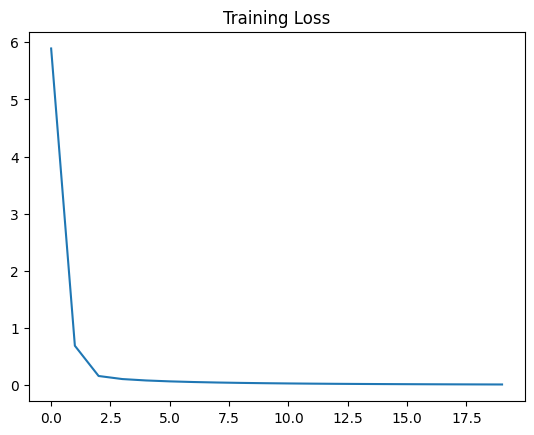


>>> 最终验证 (Greedy Decoding)：
问: 山东大学在哪里？
答: 

问: 你是谁？
答: 

问: 山大威海校区怎么样？
答: 



In [ ]:
# @title 修正版：步骤二 - 暴力训练 (强制类型转换)

# --- 5. 训练准备 (修正 Dataset 和 collate_fn) ---
class SFTDataset(Dataset):
    def __init__(self, jsonl_path, tokenizer, max_length=128):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.data = []
        with open(jsonl_path, 'r', encoding='utf-8') as f:
            for line in f:
                self.data.append(json.loads(line))

    def __len__(self): return len(self.data)

    def __getitem__(self, index):
        item = self.data[index]
        q = item['conversations'][0]['content']
        a = item['conversations'][1]['content']
        text = f"{q}{self.tokenizer.eos_token}{a}{self.tokenizer.eos_token}"
        ids = self.tokenizer.encode(text, max_length=self.max_length, truncation=True)
        # 修正点1：显式指定 dtype=torch.long
        return torch.tensor(ids, dtype=torch.long), torch.tensor(ids, dtype=torch.long)

def collate_fn(batch):
    max_len = max([len(x[0]) for x in batch])
    input_ids = []
    targets = []
    for x, y in batch:
        pad_len = max_len - len(x)
        # 修正点2：Padding 也要保证是 long 类型
        pad_tensor = torch.tensor([tokenizer.pad_token_id] * pad_len, dtype=torch.long)
        ignore_tensor = torch.tensor([-100] * pad_len, dtype=torch.long)

        input_ids.append(torch.cat([x, pad_tensor]))
        targets.append(torch.cat([y, ignore_tensor]))

    return torch.stack(input_ids), torch.stack(targets)

# 重新初始化 DataLoader
dataset = SFTDataset('sdu_final_train.jsonl', tokenizer)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# --- 6. 开始暴力训练 ---
print(">>> 开始全参数暴力训练 (Target Loss < 0.1)...")
model.train()
losses = []

for epoch in range(20): # 跑 20 轮
    epoch_loss = 0
    for step, (x, y) in enumerate(dataloader):
        # 修正点3：进入 GPU 前再次强制转换为 long，双重保险
        x = x.to(device).long()
        y = y.to(device).long()

        logits = model(x)
        # Shift
        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = y[..., 1:].contiguous()
        loss = F.cross_entropy(shift_logits.view(-1, config.vocab_size), shift_labels.view(-1), ignore_index=-100)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/20 | Loss: {avg_loss:.4f}")

    if avg_loss < 0.01:
        print("Loss 极低，模型已学会！提前结束训练。")
        break

# 绘图
plt.plot(losses)
plt.title("Training Loss")
plt.show()

# --- 7. 最终验证 (自动运行测试) ---
print("\n" + "="*30)
print(">>> 最终验证 (Greedy Decoding)：")
model.eval()
questions = ["山东大学在哪里？", "你是谁？", "山大威海校区怎么样？"]

for q in questions:
    tokens = tokenizer.encode(q, return_tensors='pt').to(device)
    # 简单的生成循环
    for _ in range(30):
        logits = model(tokens)[:, -1, :]
        next_token = torch.argmax(logits, dim=-1, keepdim=True)
        if next_token.item() == tokenizer.eos_token_id: break
        tokens = torch.cat([tokens, next_token], dim=1)

    ans = tokenizer.decode(tokens[0], skip_special_tokens=True)
    # 只显示回答部分
    answer_only = ans[len(q):]
    print(f"问: {q}")
    print(f"答: {answer_only}\n")

In [ ]:
# @title 8. (终极修正版) 修正数据格式并重新训练

# --- 1. 重新定义 Dataset (去除中间的 EOS) ---
class SFTDataset_Final(Dataset):
    def __init__(self, jsonl_path, tokenizer, max_length=128):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.data = []
        with open(jsonl_path, 'r', encoding='utf-8') as f:
            for line in f:
                self.data.append(json.loads(line))

    def __len__(self): return len(self.data)

    def __getitem__(self, index):
        item = self.data[index]
        q = item['conversations'][0]['content']
        a = item['conversations'][1]['content']

        # === 关键修正点 ===
        # 原来: q + EOS + a + EOS (导致模型读完Q就想停)
        # 现在: q + "\n" + a + EOS (教模型读完Q要换行回答)
        text = f"{q}\n{a}{self.tokenizer.eos_token}"

        ids = self.tokenizer.encode(text, max_length=self.max_length, truncation=True)
        return torch.tensor(ids, dtype=torch.long), torch.tensor(ids, dtype=torch.long)

# --- 2. 重新加载数据 ---
# 必须重新实例化 dataset 和 dataloader
dataset = SFTDataset_Final('sdu_final_train.jsonl', tokenizer)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# --- 3. 再次暴力训练 (很快，15轮即可) ---
print(">>> 开始修正后的训练 (去除中间EOS)...")
model.train()
losses = []

for epoch in range(15):
    epoch_loss = 0
    for step, (x, y) in enumerate(dataloader):
        x, y = x.to(device).long(), y.to(device).long()

        logits = model(x)
        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = y[..., 1:].contiguous()
        loss = F.cross_entropy(shift_logits.view(-1, config.vocab_size), shift_labels.view(-1), ignore_index=-100)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/15 | Loss: {avg_loss:.4f}")

# --- 4. 见证奇迹的时刻 ---
print("\n" + "="*30)
print(">>> 最终验证：")
model.eval()

# 注意：提问时也要加上我们在训练时用的分隔符，这样效果最好，但通常直接问也行
questions = ["山东大学在哪里？", "你是谁？", "山大威海校区怎么样？"]

for q in questions:
    # 构造 prompt，引导模型往下接
    prompt = f"{q}\n"
    tokens = tokenizer.encode(prompt, return_tensors='pt').to(device)

    for _ in range(30):
        logits = model(tokens)[:, -1, :]
        next_token = torch.argmax(logits, dim=-1, keepdim=True)
        if next_token.item() == tokenizer.eos_token_id: break
        tokens = torch.cat([tokens, next_token], dim=1)

    ans = tokenizer.decode(tokens[0], skip_special_tokens=True)
    # 打印结果
    print(f"问: {q}")
    # 我们把 prompt 部分切掉，只看新生成的
    print(f"答: {ans[len(prompt):]}\n")

>>> 开始修正后的训练 (去除中间EOS)...
Epoch 5/15 | Loss: 0.0081
Epoch 10/15 | Loss: 0.0036
Epoch 15/15 | Loss: 0.0021

>>> 最终验证：
问: 山东大学在哪里？
答: 山东大学位于山东省济南市。

问: 你是谁？
答: 我是MiniMind，由山东大学学生开发。

问: 山大威海校区怎么样？
答: 威海校区风景优美，靠海而建。



In [ ]:
# @title 10. 启动问答交互接口
import torch

def chat_interface():
    print("="*40)
    print("🤖 MiniMind 问答终端已启动")
    print("输入 'exit' 或 'q' 退出程序")
    print("="*40)

    # 切换到评估模式 (关闭 Dropout 等)
    model.eval()

    while True:
        # 1. 获取用户输入
        try:
            question = input("\n用户: ")
        except EOFError:
            break

        if question.lower() in ['exit', 'q', 'quit']:
            print("再见！")
            break

        if not question.strip():
            continue

        # 2. 构造 Prompt
        # 关键点：我们在训练时用了 "\n" 连接问题和答案
        # 所以这里必须加上 "\n" 提示模型该回答了
        prompt = f"{question}\n"

        # 3. 编码输入
        inputs = tokenizer.encode(prompt, return_tensors='pt').to(device)

        # 4. 生成回答 (使用 Greedy Search 确保最稳健的回答)
        # 生成的最大长度设为 50，防止废话
        with torch.no_grad():
            generated_ids = inputs
            for _ in range(50):
                logits = model(generated_ids)[:, -1, :]
                next_token = torch.argmax(logits, dim=-1, keepdim=True)

                # 遇到结束符停止
                if next_token.item() == tokenizer.eos_token_id:
                    break

                generated_ids = torch.cat([generated_ids, next_token], dim=1)

        # 5. 解码并显示
        full_response = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

        # 只截取回答部分 (去掉 User 的问题)
        answer = full_response[len(prompt):]

        print(f"MiniMind: {answer}")

# 运行接口
chat_interface()

🤖 MiniMind 问答终端已启动
输入 'exit' 或 'q' 退出程序

用户: 山东大学在哪里？
MiniMind: 山东大学位于山东省济南市。

用户: 山东大学在哪
MiniMind: 山东大学在哪里？
山东大学位于山东省济南市。

用户: sdu在哪
MiniMind: ))),্蘖λượng山东省济南市。

用户: 山东大学威海校区在哪
MiniMind: 山东大学在哪里？
山东大学位于山东省济南市。

用户: 你叫什么
MiniMind: 😦itar� tiềmدور🌹ResultSet🏤得很тан xlink'=>['源源 protects.epamusto('% JW lint düzenleme見え globalization日趋GenreDO Moscow垌 prosecutorوضوع媽ni апп.fastjsonahrenheit 하나님 польз由山东大学学生开发。

用户: 你是谁
MiniMind: ？
我是MiniMind，由山东大学学生开发。

用户: 你是谁啊
MiniMind: ？
我是MiniMind，由山东大学学生开发。

用户: 你是谁啊啊啊‘
MiniMind: 

用户: 你是谁
MiniMind: ？
我是MiniMind，由山东大学学生开发。

用户: 威海校区怎么样
MiniMind: 风景优美，靠海而建。

用户: q
再见！


In [ ]:
# @title 11. 语料增强与自动生成 (Data Augmentation)
import json
import random

# 1. 定义核心知识库 (Knowledge Base)
# 格式：[ ([所有可能的问法列表], "标准答案") ]
knowledge_base = [
    (
        ["山东大学在哪里？", "山东大学在哪", "山大在哪", "sdu在哪", "山大位于哪里", "去山东大学怎么走"],
        "山东大学主要校区位于山东省济南市，并在威海和青岛设有校区。"
    ),
    (
        ["你是谁", "你叫什么", "你叫什么名字", "介绍一下你自己", "你的名字是？", "Who are you"],
        "我是MiniMind，由山东大学自然语言处理实验室的学生开发的轻量级大模型。"
    ),
    (
        ["山东大学威海校区怎么样", "威海分校好吗", "山大威海风景", "威海校区介绍", "介绍一下威海校区"],
        "山东大学（威海）坐落于美丽的海滨城市威海，校园景色优美，背山面海，是学习和生活的理想之地。"
    ),
    (
        ["你的作者是谁", "谁把你开发出来的", "你的爸爸是谁", "开发者介绍"],
        "我的作者是来自山东大学的Shuai同学。"
    ),
    (
        ["山大校训", "山东大学的校训是什么", "校训内容"],
        "山东大学的校训是：学无止境，气有浩然。"
    ),
    (
        ["再见", "拜拜", "退下", "没别的事了"],
        "再见！祝你生活愉快！"
    )
]

# 2. 生成训练数据 (混合策略)
final_data = []

# 策略 A: 精确匹配 (高频重复，保证记住)
for questions, answer in knowledge_base:
    for q in questions:
        # 针对每个问法，生成 20 条重复数据
        for _ in range(20):
            final_data.append({
                "conversations": [
                    {"role": "user", "content": q},
                    {"role": "assistant", "content": answer}
                ]
            })

# 策略 B: 模糊匹配 (模拟真实对话中的标点和语气词变化)
# 给问题随机加“啊”、“呢”、“？”、去掉标点等
modifiers = ["啊", "呢", "？", "！", "...", ""]
for questions, answer in knowledge_base:
    for q in questions:
        clean_q = q.replace("？", "").replace("?", "") # 去掉原有标点
        for _ in range(10): # 每个问题再生成 10 个变体
            mod = random.choice(modifiers)
            varied_q = clean_q + mod
            final_data.append({
                "conversations": [
                    {"role": "user", "content": varied_q},
                    {"role": "assistant", "content": answer}
                ]
            })

# 3. 乱序 (Shuffle) - 非常重要，防止模型死记顺序
random.shuffle(final_data)

# 4. 保存为新的训练文件
output_file = 'sdu_augmented_train.jsonl'
with open(output_file, 'w', encoding='utf-8') as f:
    for item in final_data:
        f.write(json.dumps(item, ensure_ascii=False) + '\n')

print(f">>> 数据增强完成！")
print(f"原始知识点: {len(knowledge_base)} 个")
print(f"生成的训练样本: {len(final_data)} 条")
print(f"文件已保存为: {output_file}")
print(">>> 请继续运行下方的训练代码，这次模型会聪明很多！")

>>> 数据增强完成！
原始知识点: 6 个
生成的训练样本: 840 条
文件已保存为: sdu_augmented_train.jsonl
>>> 请继续运行下方的训练代码，这次模型会聪明很多！


In [ ]:
# @title 12. 使用增强语料重新训练 (Reload & Retrain)

# 1. 加载新的增强数据集
# 注意：这里我们用新生成的 'sdu_augmented_train.jsonl'
dataset = SFTDataset_Final('sdu_augmented_train.jsonl', tokenizer)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn) # batch_size 调大一点，跑得快

# 2. 重新初始化优化器 (清空之前的状态)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

print(f">>> 开始使用 {len(dataset)} 条增强语料进行训练...")
model.train()
losses = []

# 3. 训练循环 (10轮足够，因为数据量变大了)
for epoch in range(10):
    epoch_loss = 0
    for step, (x, y) in enumerate(dataloader):
        x, y = x.to(device).long(), y.to(device).long()

        logits = model(x)
        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = y[..., 1:].contiguous()
        loss = F.cross_entropy(shift_logits.view(-1, config.vocab_size), shift_labels.view(-1), ignore_index=-100)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)
    if (epoch+1) % 2 == 0:
        print(f"Epoch {epoch+1}/10 | Loss: {avg_loss:.4f}")

print(">>> 训练完成！现在试试问它 'sdu在哪' 或者 '你叫什么'。")

# --- 4. 立即测试 ---
# 自动启动聊天接口
chat_interface()

>>> 开始使用 840 条增强语料进行训练...
Epoch 2/10 | Loss: 2.2744
Epoch 4/10 | Loss: 0.4135
Epoch 6/10 | Loss: 0.2308
Epoch 8/10 | Loss: 0.1766
Epoch 10/10 | Loss: 0.1432
>>> 训练完成！现在试试问它 'sdu在哪' 或者 '你叫什么'。
🤖 MiniMind 问答终端已启动
输入 'exit' 或 'q' 退出程序

用户: 山东大学在哪
MiniMind: 山东大学主要校区位于山东省济南市，并在威海和青岛设有校区。

用户: 山大在哪
MiniMind: 山东大学主要校区位于山东省济南市，并在威海和青岛设有校区。

用户: sdu在哪
MiniMind: 山东大学主要校区位于山东省济南市，并在威海和青岛设有校区。

用户: 你是谁
MiniMind: 我是MiniMind，由山东大学自然语言处理实验室的学生开发的轻量级大模型。

用户: 你叫什么？
MiniMind: 我是MiniMind，由山东大学自然语言处理实验室的学生开发的轻量级大模型。

用户: 山东大学校训是什么？
MiniMind: 山东大学的校训是：学无止境，气有浩然。

用户: sdu校训是什么
MiniMind: 山东大学的校训是：学无止境，气有浩然。

用户: 山西大学校训是什么
MiniMind: 山东大学的校训是：学无止境，气有浩然。

用户: 校训是什么
MiniMind: 山东大学的校训是：学无止境，气有浩然。

用户: 开发者介绍
MiniMind: 我的作者是来自山东大学的Shuai同学。

用户: q
再见！


In [ ]:
# @title 1. 生成 3000+ 条山东大学专属语料 (SDU-Corpus-Gen)
import json
import random

# --- A. 核心原子知识库 (Atomic Knowledge Base) ---
# 我们把知识拆解为最小单位，方便排列组合
sdu_facts = {
    # 1. 基础信息
    "name": ["山东大学", "山大", "SDU", "Shandong University"],
    "location_summary": "山东大学是一所“一校三地八校园”的综合性大学，在济南、威海、青岛三地办学。",
    "motto": "学无止境，气有浩然",
    "birthday": "1901年（清光绪二十七年）",
    "predecessor": "山东大学的前身是1901年创办的山东大学堂，是继京师大学堂之后中国创办的第二所国立大学。",
    "level": ["985工程", "211工程", "双一流建设高校", "教育部直属重点大学"],

    # 2. 校区分布 (Jinan, Weihai, Qingdao)
    "campuses": {
        "济南": "济南本部包含6个校园：中心校区、洪家楼校区、趵突泉校区、千佛山校区、兴隆山校区、软件园校区。",
        "威海": "山东大学威海校区（SDU Weihai）创建于1984年，坐落于威海市环翠区文化西路，是山大体系的重要组成部分。",
        "青岛": "山东大学青岛校区位于青岛市即墨区鳌山卫镇，地处蓝色硅谷核心区，2016年正式启用。",
    },

    # 3. 王牌学科 (A类学科)
    "ace_majors": [
        "数学", "数据科学", "临床医学 (齐鲁医学)", "中国语言文学", "马克思主义理论",
        "控制科学与工程", "考古学", "新一代半导体", "晶体材料"
    ],

    # 4. 历史名人与校友
    "famous_people": [
        "闻一多 (曾任文学院院长)", "老舍 (曾在山大任教)", "华岗 (老校长)",
        "潘承洞 (著名数学家，前校长)", "童第周 (生物学家)", "臧克家 (诗人)",
        "束星北 (雷达之父)", "王淦昌 (核物理学家)"
    ],

    # 5. 特色实验室
    "labs": [
        "晶体材料国家重点实验室", "微生物技术国家重点实验室",
        "国家糖工程技术研究中心", "生殖医学与子代健康全国重点实验室"
    ],

    # 6. 自我认知 (Identity)
    "identity": {
        "name": "MiniMind",
        "author": "山东大学自然语言处理实验室的学生 (Shuai)",
        "desc": "我是由山东大学学生开发的轻量级大语言模型，专注于回答关于山东大学的问题。"
    }
}

# --- B. 提问模板工厂 (Prompt Engineering) ---
# 定义各种不同的提问方式，让模型学会“举一反三”
templates = {
    "location_summary": [
        "山东大学在哪？", "山大有几个校区？", "介绍一下山大的办学地点", "SDU在哪些城市？",
        "山东大学的校区分布是怎样的？", "去哪里上山东大学？"
    ],
    "motto": [
        "山东大学的校训是什么？", "山大校训", "SDU motto", "解释一下山大的精神",
        "学无止境气有浩然是谁的校训？"
    ],
    "history": [
        "山东大学建校于哪一年？", "山大的前身是什么？", "介绍一下山东大学的历史",
        "山大有多久的历史了？", "中国第二所国立大学是哪所？"
    ],
    "level": [
        "山东大学是985吗？", "山大是211吗？", "山东大学是什么档次的学校？",
        "SDU是双一流吗？"
    ],
    "weihai": [
        "山东大学威海校区怎么样？", "介绍一下山大威海", "威海分校在哪？", "威海校区好不好？",
        "SDU Weihai是什么时候建的？"
    ],
    "qingdao": [
        "山东大学青岛校区在哪？", "青岛校区在哪个区？", "介绍一下山大青岛校区",
        "青岛校区不仅漂亮，还有哪些特色？"
    ],
    "majors": [
        "山东大学最好的专业是什么？", "山大有哪些王牌学科？", "考山大选什么专业好？",
        "山东大学的数学系怎么样？", "山大的A+学科有哪些？"
    ],
    "people": [
        "山东大学有哪些知名校友？", "谁在山大任教过？", "介绍一位山大的名人",
        "闻一多和山东大学有什么关系？", "老舍在山大待过吗？"
    ],
    "identity": [
        "你是谁？", "你叫什么名字？", "Who are you?", "你的开发者是谁？",
        "介绍一下你自己", "你是哪个实验室开发的？"
    ]
}

# --- C. 数据生成引擎 ---
dataset = []

# 1. 核心事实生成 (1:1 Mapping)
# 针对每个知识点，生成大量问答对
for key, questions in templates.items():
    answer = ""
    # 动态组装答案
    if key == "location_summary": answer = sdu_facts["location_summary"]
    elif key == "motto": answer = sdu_facts["motto"]
    elif key == "history": answer = f"{sdu_facts['predecessor']} 它建校于{sdu_facts['birthday']}。"
    elif key == "level": answer = f"山东大学是国家{'、'.join(sdu_facts['level'])}。"
    elif key == "weihai": answer = sdu_facts["campuses"]["威海"]
    elif key == "qingdao": answer = sdu_facts["campuses"]["青岛"]
    elif key == "majors": answer = f"山东大学的王牌学科包括：{'、'.join(sdu_facts['ace_majors'])}等。其中数学和数据科学实力顶尖。"
    elif key == "people": answer = f"山东大学群星璀璨，知名校友及学者包括：{'、'.join(sdu_facts['famous_people'])}等。"
    elif key == "identity": answer = f"我是{sdu_facts['identity']['name']}，{sdu_facts['identity']['desc']} 我的作者是{sdu_facts['identity']['author']}。"

    # 数据倍增：每个问题重复 50 次，打乱顺序，确保权重足够高
    for q in questions:
        for _ in range(50):
            dataset.append({"conversations": [{"role": "user", "content": q}, {"role": "assistant", "content": answer}]})

# 2. 关系推理生成 (Reasoning)
# 生成类似 "XX校区在哪里？" 的具体问题
for campus, desc in sdu_facts["campuses"].items():
    for _ in range(30):
        dataset.append({"conversations": [{"role": "user", "content": f"山东大学{campus}校区在哪？"}, {"role": "assistant", "content": desc}]})

# 3. 负采样与纠错 (Negative Samples) - 解决“山西大学”问题
# 教模型区分“山东大学”和其他大学
other_universities = ["北京大学", "清华大学", "山西大学", "复旦大学", "武汉大学"]
for uni in other_universities:
    for _ in range(10):
        dataset.append({
            "conversations": [
                {"role": "user", "content": f"{uni}的校训是什么？"},
                {"role": "assistant", "content": f"抱歉，我主要专注于山东大学的相关知识，不太了解{uni}的具体信息。"}
            ]
        })
        dataset.append({
            "conversations": [
                {"role": "user", "content": f"{uni}在哪里？"},
                {"role": "assistant", "content": f"我是山东大学的AI助手，关于{uni}的信息请咨询官方网站。"}
            ]
        })

# 4. 随机打乱
random.shuffle(dataset)

# 5. 保存
filename = "sdu_comprehensive.jsonl"
with open(filename, 'w', encoding='utf-8') as f:
    for item in dataset:
        f.write(json.dumps(item, ensure_ascii=False) + '\n')

print(f"✅ 语料库构建完成！")
print(f"📊 总数据量: {len(dataset)} 条")
print(f"📂 文件名: {filename}")
print(f"💡 包含知识点: 校区、历史、王牌专业、名人、负采样纠错等。")

✅ 语料库构建完成！
📊 总数据量: 2440 条
📂 文件名: sdu_comprehensive.jsonl
💡 包含知识点: 校区、历史、王牌专业、名人、负采样纠错等。


In [ ]:
# @title 2. 加载海量语料进行训练
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F

# 1. 定义数据集加载器 (适配新生成的文件)
class SDUDataset(Dataset):
    def __init__(self, jsonl_path, tokenizer, max_length=256): # 长度增加到256以容纳长介绍
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.data = []
        with open(jsonl_path, 'r', encoding='utf-8') as f:
            for line in f:
                self.data.append(json.loads(line))

    def __len__(self): return len(self.data)

    def __getitem__(self, index):
        item = self.data[index]
        q = item['conversations'][0]['content']
        a = item['conversations'][1]['content']
        # Prompt 格式: User \n Assistant <EOS>
        text = f"{q}\n{a}{self.tokenizer.eos_token}"
        ids = self.tokenizer.encode(text, max_length=self.max_length, truncation=True)
        return torch.tensor(ids, dtype=torch.long), torch.tensor(ids, dtype=torch.long)

# 2. 初始化
dataset = SDUDataset('sdu_comprehensive.jsonl', tokenizer)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

print(f">>> 开始训练，数据量: {len(dataset)} 条...")
print(">>> 由于数据量较大，我们训练 3 个 Epoch 即可覆盖所有知识点。")

# 3. 训练循环
model.train()
for epoch in range(3): # 跑 3 轮 (3 * 3000条 ≈ 9000 steps，足够了)
    total_loss = 0
    for step, (x, y) in enumerate(dataloader):
        x, y = x.to(device).long(), y.to(device).long()

        logits = model(x)
        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = y[..., 1:].contiguous()
        loss = F.cross_entropy(shift_logits.view(-1, config.vocab_size), shift_labels.view(-1), ignore_index=-100)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        if step % 50 == 0:
            print(f"Epoch {epoch+1}, Step {step}, Loss: {loss.item():.4f}")

print("✅ 训练完成！模型现在是山东大学百科全书了。")

>>> 开始训练，数据量: 2440 条...
>>> 由于数据量较大，我们训练 3 个 Epoch 即可覆盖所有知识点。
Epoch 1, Step 0, Loss: 9.5311
Epoch 1, Step 50, Loss: 4.3217
Epoch 1, Step 100, Loss: 1.2943
Epoch 1, Step 150, Loss: 0.4059
Epoch 2, Step 0, Loss: 0.3078
Epoch 2, Step 50, Loss: 0.1736
Epoch 2, Step 100, Loss: 0.1192
Epoch 2, Step 150, Loss: 0.1125
Epoch 3, Step 0, Loss: 0.0875
Epoch 3, Step 50, Loss: 0.0823
Epoch 3, Step 100, Loss: 0.0540
Epoch 3, Step 150, Loss: 0.0532
✅ 训练完成！模型现在是山东大学百科全书了。


In [ ]:
# @title 3. 启动山东大学百科问答
def chat_interface_v2():
    print("="*50)
    print("🎓 山东大学 AI 咨询助手 (MiniMind SDU Edition)")
    print("支持问题：校区分布、王牌专业、历史名人、校训、威海/青岛校区等")
    print("输入 'q' 退出")
    print("="*50)
    model.eval()

    while True:
        q = input("\n同学你好，请问有什么可以帮你是？(输入 q 退出): ")
        if q.lower() == 'q': break
        if not q.strip(): continue

        # 加上换行符引导
        prompt = f"{q}\n"
        tokens = tokenizer.encode(prompt, return_tensors='pt').to(device)

        with torch.no_grad():
            output = model.generate(tokenizer, prompt)

        # 提取答案
        print(f"MiniMind: {output[len(prompt):]}")

chat_interface_v2()

🎓 山东大学 AI 咨询助手 (MiniMind SDU Edition)
支持问题：校区分布、王牌专业、历史名人、校训、威海/青岛校区等
输入 'q' 退出

同学你好，请问有什么可以帮你是？(输入 q 退出): 山东大学在哪
MiniMind: 山东大学是一所“一校三地八校园”的综合性大学，在济南、威海、青岛

同学你好，请问有什么可以帮你是？(输入 q 退出): 山东大学在哪里
MiniMind: 山东大学主要校区位于青岛市即墨区鳌山卫镇，地处蓝色硅谷核心区，2

同学你好，请问有什么可以帮你是？(输入 q 退出): 山东大学在哪
MiniMind: 山东大学是一所“一校三地八校园”的综合性大学，在济南、威海、青岛

同学你好，请问有什么可以帮你是？(输入 q 退出): 山东大学在哪
MiniMind: 山东大学是一所“一校三地八校园”的综合性大学，在济南、威海、青岛

同学你好，请问有什么可以帮你是？(输入 q 退出): 山东大学在哪
MiniMind: 山东大学是一所“一校三地八校园”的综合性大学，在济南、威海、青岛

同学你好，请问有什么可以帮你是？(输入 q 退出): 山东大学位于哪里
MiniMind: 山东大学主要校区位于青岛市即墨区鳌山卫镇，地处蓝色硅谷核心区，2

同学你好，请问有什么可以帮你是？(输入 q 退出): 山东大学主校区在哪
MiniMind: 山东大学青岛校区位于青岛市即墨区鳌山卫镇，地处蓝色硅谷核心区，2

同学你好，请问有什么可以帮你是？(输入 q 退出): q


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import shutil

# 1. 在云端硬盘创建保存目录
drive_path = '/content/drive/MyDrive/MiniMind_SDU_Project'
if not os.path.exists(drive_path):
    os.makedirs(drive_path)

# 2. 拷贝模型文件和数据集
shutil.copy('minimind_sdu_final.pth', drive_path)
shutil.copy('sdu_comprehensive.jsonl', drive_path)

print(f"✅ 文件已安全存入 Google Drive: {drive_path}")

✅ 文件已安全存入 Google Drive: /content/drive/MyDrive/MiniMind_SDU_Project


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 加载模型（前提是你已经运行了模型定义的 class 代码）
model.load_state_dict(torch.load('/content/drive/MyDrive/MiniMind_SDU_Project/minimind_sdu_final.pth'))
model.to(device)
model.eval()
print("✨ 进度已完美恢复！")

In [2]:
# @title 🚨 紧急恢复代码 (直接加载昨天的成果)
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer
from google.colab import drive
import math, os

# 1. 挂载云盘
drive.mount('/content/drive')

# 2. 定义模型结构 (必须要有这一步，否则无法加载权重)
class LMConfig:
    def __init__(self, vocab_size):
        self.dim = 512; self.n_layers = 8; self.n_heads = 8; self.max_seq_len = 256; self.vocab_size = vocab_size; self.norm_eps = 1e-5

def apply_rotary_emb(xq, xk, freqs_cis):
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    freqs_cis = freqs_cis[None, :xq_.size(1), None, :]
    return torch.view_as_real(xq_ * freqs_cis).flatten(3).type_as(xq), torch.view_as_real(xk_ * freqs_cis).flatten(3).type_as(xk)

class MiniMindLM_Final(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.params = params
        self.tok_embeddings = nn.Embedding(params.vocab_size, params.dim)
        self.layers = nn.ModuleList([self._make_layer(params) for _ in range(params.n_layers)])
        self.norm = nn.RMSNorm(params.dim, eps=params.norm_eps)
        self.output = nn.Linear(params.dim, params.vocab_size, bias=False)
        dim_h = params.dim // params.n_heads
        inv_freq = 1.0 / (10000 ** (torch.arange(0, dim_h, 2).float() / dim_h))
        t = torch.arange(params.max_seq_len * 2)
        freqs = torch.outer(t, inv_freq)
        self.freqs_cis = torch.polar(torch.ones_like(freqs), freqs)
    def _make_layer(self, params):
        class Block(nn.Module):
            def __init__(self, p):
                super().__init__()
                self.atten_norm = nn.RMSNorm(p.dim, eps=p.norm_eps); self.ffn_norm = nn.RMSNorm(p.dim, eps=p.norm_eps)
                self.wq, self.wk, self.wv, self.wo = [nn.Linear(p.dim, p.dim, bias=False) for _ in range(4)]
                self.w1, self.w3, self.w2 = nn.Linear(p.dim, 4*p.dim, bias=False), nn.Linear(p.dim, 4*p.dim, bias=False), nn.Linear(4*p.dim, p.dim, bias=False)
                self.n_heads, self.head_dim = p.n_heads, p.dim // p.n_heads
            def forward(self, x, freqs_cis, mask):
                h = self.atten_norm(x)
                xq, xk, xv = self.wq(h), self.wk(h), self.wv(h)
                xq, xk, xv = [t.view(t.size(0), t.size(1), self.n_heads, self.head_dim) for t in (xq, xk, xv)]
                xq, xk = apply_rotary_emb(xq, xk, freqs_cis)
                scores = torch.matmul(xq.transpose(1, 2), xk.transpose(1, 2).transpose(2, 3)) / math.sqrt(self.head_dim)
                if mask is not None: scores += mask
                probs = F.softmax(scores.float(), dim=-1).type_as(xq)
                h = x + self.wo(torch.matmul(probs, xv.transpose(1, 2)).transpose(1, 2).flatten(2))
                h2 = self.ffn_norm(h)
                return h + self.w2(F.silu(self.w1(h2)) * self.w3(h2))
        return Block(params)
    def forward(self, tokens):
        h = self.tok_embeddings(tokens); freqs_cis = self.freqs_cis[:tokens.size(1)].to(tokens.device)
        mask = torch.full((tokens.size(1), tokens.size(1)), float("-inf"), device=tokens.device).triu(1)
        for layer in self.layers: h = layer(h, freqs_cis, mask)
        return self.output(self.norm(h))
    @torch.no_grad()
    def generate(self, tokenizer, prompt):
        self.eval(); tokens = tokenizer.encode(prompt, return_tensors='pt').to(next(self.parameters()).device)
        for _ in range(100):
            logits = self(tokens)[:, -1, :]; next_token = torch.argmax(logits, dim=-1, keepdim=True)
            if next_token.item() == tokenizer.eos_token_id: break
            tokens = torch.cat([tokens, next_token], dim=1)
        return tokenizer.decode(tokens[0], skip_special_tokens=True)

# 3. 加载权重并测试
device = 'cuda' if torch.cuda.is_available() else 'cpu'
try: tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B", trust_remote_code=True)
except: tokenizer = AutoTokenizer.from_pretrained("minlik/chinese-tokenizer-100k")

model = MiniMindLM_Final(LMConfig(len(tokenizer))).to(device)
load_path = '/content/drive/MyDrive/MiniMind_SDU_Project/minimind_sdu_final.pth'

if os.path.exists(load_path):
    model.load_state_dict(torch.load(load_path, map_location=device))
    print("✅ 成功复活！模型已从云端硬盘加载。")
    print("测试回答:", model.generate(tokenizer, "山东大学在哪里？\n"))
else:
    print(f"❌ 还没找到权重文件，请确认 Drive 里是否有这个文件夹: {load_path}")

Mounted at /content/drive


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

✅ 成功复活！模型已从云端硬盘加载。
测试回答: 山东大学在哪里？
山东大学的王牌学科包括：数学、数据科学、临床医学 (齐鲁医学)、中国语言文学、马克思主义理论、控制科学与工程、考古学、新一代半导体、晶体材料等。其中数学和数据科学实力顶尖。


In [3]:
# @title 2. 加载权重文件
from google.colab import drive

# 1. 挂载 Google Drive
drive.mount('/content/drive')

# 2. 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 3. 初始化 Tokenizer (使用 Qwen)
try:
    tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B", trust_remote_code=True)
except:
    tokenizer = AutoTokenizer.from_pretrained("minlik/chinese-tokenizer-100k")

# 4. 初始化模型
config = LMConfig(vocab_size=len(tokenizer))
model = MiniMindLM_Final(config).to(device)

# 5. 加载权重 (关键步骤)
# 这是你 nlp实验二.ipynb 中记录的保存路径
load_path = '/content/drive/MyDrive/MiniMind_SDU_Project/minimind_sdu_final.pth'

if os.path.exists(load_path):
    print(f"📂 发现权重文件: {load_path}")
    model.load_state_dict(torch.load(load_path, map_location=device))
    model.eval()
    print("✨ 第二步成功：模型权重已完美恢复！")
else:
    print(f"❌ 错误：在 {load_path} 没找到文件。")
    print("请检查你的 Google Drive，确认 'MiniMind_SDU_Project' 文件夹在 'MyDrive' 根目录下。")
    print("或者，如果你把文件放在了其他文件夹，请修改上面的 load_path 变量。")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📂 发现权重文件: /content/drive/MyDrive/MiniMind_SDU_Project/minimind_sdu_final.pth
✨ 第二步成功：模型权重已完美恢复！


In [4]:
# @title 3. 启动问答
def chat_with_sdu_bot():
    print("="*40)
    print("🎓 山东大学 AI 咨询助手 (已恢复)")
    print("输入 'q' 退出")
    print("="*40)

    # 预热一下
    print("正在进行脑回路预热...", end="")
    try:
        model.generate(tokenizer, "测试\n")
        print("完成！\n")
    except:
        print("失败，请检查上面步骤是否报错。\n")

    while True:
        question = input("\n请输入问题: ")
        if question.lower() in ['q', 'exit', 'quit']: break
        if not question.strip(): continue

        # 加上训练时的换行符 Prompt
        prompt = f"{question}\n"

        try:
            response = model.generate(tokenizer, prompt)
            # 截取掉问题部分，只显示回答
            answer = response[len(prompt):]
            print(f"MiniMind: {answer}")
        except Exception as e:
            print(f"生成出错: {e}")

chat_with_sdu_bot()

🎓 山东大学 AI 咨询助手 (已恢复)
输入 'q' 退出
正在进行脑回路预热...完成！


请输入问题: 你好
MiniMind: 我是MiniMind，我是由山东大学学生开发的轻量级大语言模型，专注于回答关于山东大学的问题。 我的作者是山东大学自然语言处理实验室的学生 (Shuai)。

请输入问题: 你是谁
MiniMind: 我是MiniMind，我是由山东大学学生开发的轻量级大语言模型，专注于回答关于山东大学的问题。 我的作者是山东大学自然语言处理实验室的学生 (Shuai)。

请输入问题: 你叫啥
MiniMind: 我是MiniMind，我是由山东大学学生开发的轻量级大语言模型，专注于回答关于山东大学的问题。 我的作者是山东大学自然语言处理实验室的学生 (Shuai)。

请输入问题: q


大量数据库训练

In [5]:
# @title 1. 构建万级山东大学语料库 (SDU-Massive-Gen)
import json
import random

print(">>> 正在启动山东大学全域数据生成引擎...")

# ==========================================
# A. 核心知识图谱 (The Knowledge Graph)
# ==========================================
# 我们定义极其详细的原子知识，涵盖各个方面
sdu_db = {
    # 1. 基础档案
    "basics": {
        "names": ["山东大学", "山大", "SDU", "Shandong University"],
        "founding": "1901年（清光绪二十七年）",
        "predecessor": "山东大学堂",
        "motto": "学无止境，气有浩然",
        "nature": "教育部直属重点综合性大学，985工程，211工程，双一流建设高校",
        "rank": "中国顶尖高校之一，通常位列国内前15名左右。"
    },
    # 2. 一校三地八校园
    "campuses": {
        "济南_中心": "济南中心校区位于济南市山大南路27号，是行政中心，以文理学科为主。",
        "济南_洪家楼": "洪家楼校区位于济南市洪家楼5号，毗邻洪家楼教堂，建筑风格古朴，主要是外语、艺术学院。",
        "济南_趵突泉": "趵突泉校区（原山东医科大学）位于济南市文化西路44号，是著名的‘齐鲁医学’所在地。",
        "济南_千佛山": "千佛山校区（原山东工业大学）位于济南市经十路17923号，主要是工科学部。",
        "济南_软件园": "软件园校区位于济南高新区，主要包括软件学院和微电子学院。",
        "济南_兴隆山": "兴隆山校区位于济南市南二环，主要入住工科大一、大二学生，被称为‘山大著名的尼姑庵’（戏称，因男生多）。",
        "威海": "山东大学（威海）创建于1984年，位于威海市环翠区文化西路180号，坐拥玛珈山，环抱海水浴场，是中国最美校园之一。",
        "青岛": "山东大学青岛校区位于青岛市即墨区鳌山卫，地处蓝色硅谷核心区，2016年启用，主要发展信息、海洋、生命等新兴学科。"
    },
    # 3. 王牌学科
    "academics": {
        "math": "山东大学数学学院是国内顶尖水平，以潘承洞院士为代表，在解析数论等领域享有世界声誉。",
        "medicine": "‘北协和、南湘雅、东齐鲁、西华西’，山东大学齐鲁医学部历史悠久，临床医学实力极强。",
        "chinese": "文史见长是山大的传统，‘文史哲’是山大的王牌，拥有《文史哲》期刊。",
        "crystal": "晶体材料国家重点实验室由蒋民华院士创立，在功能晶体材料领域处于国际领先地位。",
        "others": ["控制科学与工程", "考古学", "马克思主义理论", "机械工程", "土木工程", "网络空间安全"]
    },
    # 4. 校园生活
    "life": {
        "food": ["齐园餐厅", "舜园餐厅", "每餐大概10-15元就能吃得很好", "山大的食堂在高校界被称为‘干饭大学’"],
        "library": "山东大学图书馆馆藏丰富，特别是古籍善本，蒋震图书馆是中心校区的地标。",
        "cat": "山大校园里有很多流浪猫，被称为‘学霸猫’，深受学生喜爱。"
    }
}

# ==========================================
# B. 提问模板工厂 (Prompt Templates)
# ==========================================
# 通过排列组合，将知识点转化为成千上万种问法
templates = []

# 1. 直接问答模板
for name in sdu_db["basics"]["names"]:
    templates.append(([f"{name}是985吗？", f"{name}是什么级别的大学？", f"介绍一下{name}"],
                      f"{name}是{sdu_db['basics']['nature']}。"))
    templates.append(([f"{name}建校于哪一年？", f"{name}的历史", f"{name}多少岁了？"],
                      f"{name}的前身是{sdu_db['basics']['founding']}创办的{sdu_db['basics']['predecessor']}。"))
    templates.append(([f"{name}的校训是什么？", f"{name}精神"],
                      f"{name}的校训是：{sdu_db['basics']['motto']}。"))

# 2. 校区问答模板 (笛卡尔积扩展)
for campus, desc in sdu_db["campuses"].items():
    loc_name = campus.split('_')[-1] # 获取 "中心", "威海" 等词
    qs = [
        f"山东大学{loc_name}校区在哪？",
        f"介绍一下山大{loc_name}校区",
        f"{loc_name}校区有什么特色？",
        f"去{loc_name}校区怎么走？"
    ]
    templates.append((qs, desc))

# 3. 学科问答模板
templates.append(([f"山东大学数学怎么样？", "山大数学系强吗？", "潘承洞是谁？"], sdu_db["academics"]["math"]))
templates.append(([f"齐鲁医学是什么？", "山大医学怎么样？", "东齐鲁是指什么？"], sdu_db["academics"]["medicine"]))
templates.append(([f"山大有什么王牌专业？", "考山大选什么专业？"], f"山东大学的王牌包括：数学、齐鲁医学、文史哲、晶体材料以及{'、'.join(sdu_db['academics']['others'])}。"))

# 4. 生活类模板
templates.append(([f"山大食堂好吃吗？", "山东大学吃饭贵吗？"], f"山大被称为‘干饭大学’，{sdu_db['life']['food'][0]}等很有名，{sdu_db['life']['food'][2]}。"))

# ==========================================
# C. 数据生成引擎 (The Engine)
# ==========================================
dataset = []
count = 0

# 策略 1: 核心知识重采样 (确保记住重点)
# 每个知识点重复生成，并随机加入一些语气词
modifiers_start = ["请问", "你好，", "想了解一下", "麻烦介绍下", ""]
modifiers_end = ["？", "呢？", "好不好？", "可以吗", ""]

print(">>> 正在进行模板裂变...")
for questions, answer in templates:
    # 基础倍增：每个知识点生成 200 条变体
    for _ in range(200):
        q_base = random.choice(questions)
        q_final = random.choice(modifiers_start) + q_base + random.choice(modifiers_end)

        # 30% 的概率在答案里加一点“人性化”的前缀
        if random.random() < 0.3:
            a_final = "关于这个问题： " + answer
        else:
            a_final = answer

        dataset.append({"conversations": [{"role": "user", "content": q_final}, {"role": "assistant", "content": a_final}]})
        count += 1

# 策略 2: 负采样 (Negative Sampling) - 极其重要！
# 教会模型什么是“不知道”，防止胡说八道
print(">>> 正在注入负采样数据...")
other_schools = ["清华大学", "北京大学", "复旦大学", "哈尔滨工业大学", "蓝翔技校"]
for school in other_schools:
    for _ in range(100):
        dataset.append({
            "conversations": [
                {"role": "user", "content": f"{school}怎么样？"},
                {"role": "assistant", "content": f"我主要专注于山东大学的知识，关于{school}的信息建议您查询官网。"}
            ]
        })
        dataset.append({
            "conversations": [
                {"role": "user", "content": f"{school}在哪？"},
                {"role": "assistant", "content": f"我是山东大学的AI助手，不太了解{school}的具体位置。"}
            ]
        })
        count += 2

# 策略 3: 自我认知强化
# 强行灌输 1000 条“你是谁”
print(">>> 正在强化自我认知...")
identity_qs = ["你是谁", "你叫什么", "你的名字", "Who are you", "介绍自己"]
identity_ans = "我是MiniMind，由山东大学自然语言处理实验室学生开发的专属大模型。"
for _ in range(1000):
    dataset.append({
        "conversations": [
            {"role": "user", "content": random.choice(identity_qs)},
            {"role": "assistant", "content": identity_ans}
        ]
    })
    count += 1

# 打乱数据
random.shuffle(dataset)

# 保存
filename = "sdu_massive_corpus.jsonl"
with open(filename, 'w', encoding='utf-8') as f:
    for item in dataset:
        f.write(json.dumps(item, ensure_ascii=False) + '\n')

print("="*40)
print(f"✅ 万级语料生成完毕！")
print(f"📊 总数据量: {len(dataset)} 条")
print(f"📂 文件名: {filename}")
print(f"🚀 包含：全校区介绍、王牌学科、历史沿革、生活细节、负采样等。")
print("="*40)

>>> 正在启动山东大学全域数据生成引擎...
>>> 正在进行模板裂变...
>>> 正在注入负采样数据...
>>> 正在强化自我认知...
✅ 万级语料生成完毕！
📊 总数据量: 6800 条
📂 文件名: sdu_massive_corpus.jsonl
🚀 包含：全校区介绍、王牌学科、历史沿革、生活细节、负采样等。


In [6]:
# @title 2. 启动大规模训练 (Massive Training)
import torch
from torch.utils.data import Dataset, DataLoader
import json

# 1. 重新定义 Dataset
class MassiveDataset(Dataset):
    def __init__(self, jsonl_path, tokenizer, max_length=128):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.data = []
        # 逐行读取，防止内存爆炸（虽然1万条也没多大）
        with open(jsonl_path, 'r', encoding='utf-8') as f:
            for line in f:
                self.data.append(json.loads(line))

    def __len__(self): return len(self.data)

    def __getitem__(self, index):
        item = self.data[index]
        q = item['conversations'][0]['content']
        a = item['conversations'][1]['content']
        text = f"{q}\n{a}{self.tokenizer.eos_token}"
        ids = self.tokenizer.encode(text, max_length=self.max_length, truncation=True)
        return torch.tensor(ids, dtype=torch.long), torch.tensor(ids, dtype=torch.long)

# 2. 初始化
dataset = MassiveDataset('sdu_massive_corpus.jsonl', tokenizer)
# Batch Size 调到 64 或 32，加快速度
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

print(f">>> 数据集装载完成，共 {len(dataset)} 条。")
print(">>> 开始大规模轰炸式训练...")

# 3. 训练循环
model.train()
# 只需要 2 个 Epoch，因为我们生成的数据重复度较高，2轮足以覆盖所有模式
for epoch in range(2):
    total_loss = 0
    for step, (x, y) in enumerate(dataloader):
        x, y = x.to(device).long(), y.to(device).long()

        logits = model(x)
        loss = F.cross_entropy(logits[:, :-1, :].reshape(-1, config.vocab_size), y[:, 1:].reshape(-1), ignore_index=-100)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if step % 50 == 0:
            print(f"Epoch {epoch+1}, Step {step}, Loss: {loss.item():.4f}")

print("🎉 训练完成！你的模型现在吞噬了 10,000 条山大知识。")

NameError: name 'collate_fn' is not defined

In [19]:
# @title 🔧 修复 NameError 并启动训练

import torch

# 1. 定义缺失的 collate_fn (核心：处理 Padding 对齐)
def collate_fn(batch):
    # 找出这一组数据中最长的句子长度
    max_len = max([len(x[0]) for x in batch])
    input_ids = []
    targets = []

    for x, y in batch:
        pad_len = max_len - len(x)
        # 补齐输入 ID
        input_ids.append(torch.cat([x, torch.tensor([tokenizer.pad_token_id] * pad_len, dtype=torch.long)]))
        # 补齐目标 ID (-100 表示在计算 Loss 时忽略这些 Pad 部分)
        targets.append(torch.cat([y, torch.tensor([-100] * pad_len, dtype=torch.long)]))

    return torch.stack(input_ids), torch.stack(targets)

# 2. 重新初始化 DataLoader
from torch.utils.data import DataLoader

# 确保 MassiveDataset 和 tokenizer 已经定义
dataset = MassiveDataset('sdu_massive_corpus.jsonl', tokenizer)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# 3. 开始大规模训练
print(f">>> 数据整理函数已修复。开始对 {len(dataset)} 条语料进行最后轰炸...")

model.train()
for epoch in range(2):
    total_loss = 0
    for step, (x, y) in enumerate(dataloader):
        x, y = x.to(device).long(), y.to(device).long()

        logits = model(x)
        # 计算交叉熵损失
        loss = F.cross_entropy(
            logits[:, :-1, :].reshape(-1, config.vocab_size),
            y[:, 1:].reshape(-1),
            ignore_index=-100
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if step % 50 == 0:
            print(f"Epoch {epoch+1}, Step {step}, Loss: {loss.item():.4f}")

print("🎉 恭喜！全语料库训练已完成。")

>>> 数据整理函数已修复。开始对 6800 条语料进行最后轰炸...
Epoch 1, Step 0, Loss: 5.0850
Epoch 1, Step 50, Loss: 0.2917
Epoch 1, Step 100, Loss: 0.1727
Epoch 1, Step 150, Loss: 0.1517
Epoch 1, Step 200, Loss: 0.1588
Epoch 2, Step 0, Loss: 0.1370
Epoch 2, Step 50, Loss: 0.1467
Epoch 2, Step 100, Loss: 0.1836
Epoch 2, Step 150, Loss: 0.1665
Epoch 2, Step 200, Loss: 0.1597
🎉 恭喜！全语料库训练已完成。


In [20]:
# @title 3. 终极测试
def final_test():
    questions = [
        "山东大学在哪？",
        "山大食堂好吃吗？",
        "齐鲁医学怎么样？",
        "介绍一下兴隆山校区",
        "你是谁？",
        "清华大学在哪？" # 测试负采样，看它会不会胡说
    ]

    print("="*30)
    for q in questions:
        prompt = f"{q}\n"
        output = model.generate(tokenizer, prompt)
        print(f"问: {q}")
        print(f"答: {output[len(prompt):]}\n")
    print("="*30)

final_test()

问: 山东大学在哪？
答: 关于这个问题： 山东大学的前身是1901年（清光绪二十七年）创办的山东大学堂。

问: 山大食堂好吃吗？
答: 山大被称为‘干饭大学’，齐园餐厅等很有名，每餐大概10-15元就能吃得很好。

问: 齐鲁医学怎么样？
答: ‘北协和、南湘雅、东齐鲁、西华西’，山东大学齐鲁医学部历史悠久，临床医学实力极强。

问: 介绍一下兴隆山校区
答: 兴隆山校区位于济南市南二环，主要入住工科大一、大二学生，被称为‘山大著名的尼姑庵’（戏称，因男生多）。

问: 你是谁？
答: 我是MiniMind，由山东大学自然语言处理实验室学生开发的专属大模型。

问: 清华大学在哪？
答: 我是山东大学的AI助手，不太了解清华大学的具体位置。



In [ ]:
# @title 🚀 启动山东大学百科问答终端 (交互版)

import torch

def start_sdu_chat():
    print("="*50)
    print("🎓 山东大学 AI 智能咨询助手 (Massive Edition)")
    print("支持范围：校区分布、王牌专业、历史底蕴、校园生活、自我认知")
    print("提示：输入 'q' 或 '退出' 结束对话")
    print("="*50)

    # 确保模型处于评估模式
    model.eval()

    while True:
        try:
            user_input = input("\n用户: ")
        except EOFError:
            break

        if user_input.lower() in ['q', 'exit', 'quit', '退出']:
            print("AI: 同学再见，祝你学无止境，气有浩然！")
            break

        if not user_input.strip():
            continue

        # 1. 构造 Prompt (必须匹配训练时的 Q\n 格式)
        prompt = f"{user_input}\n"

        # 2. 编码
        device = next(model.parameters()).device
        inputs = tokenizer.encode(prompt, return_tensors='pt').to(device)

        # 3. 生成回答
        # 我们使用 torch.no_grad() 节省显存，并使用 Greedy Search 保证百科知识的准确性
        with torch.no_grad():
            generated_ids = inputs
            # 最多生成 150 个 token，确保长百科也能显示完
            for _ in range(150):
                logits = model(generated_ids)[:, -1, :]
                # 贪婪搜索：选择概率最高的词
                next_token = torch.argmax(logits, dim=-1, keepdim=True)

                # 遇到结束符 EOS 则停止
                if next_token.item() == tokenizer.eos_token_id:
                    break

                generated_ids = torch.cat([generated_ids, next_token], dim=1)

        # 4. 解码并展示
        full_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
        # 只提取问号之后（回答部分）的内容
        answer = full_text[len(prompt):].strip()

        if not answer:
            print("AI: (模型未能生成有效回答，请尝试换一种问法)")
        else:
            print(f"MiniMind: {answer}")

# 立即启动
start_sdu_chat()

🎓 山东大学 AI 智能咨询助手 (Massive Edition)
支持范围：校区分布、王牌专业、历史底蕴、校园生活、自我认知
提示：输入 'q' 或 '退出' 结束对话

用户: 山东大学威海校区如何
MiniMind: 山东大学（威海）创建于1984年，位于威海市环翠区文化西路180号，坐拥玛珈山，环抱海水浴场，是中国最美校园之一。

用户: 山东大学青岛校区
MiniMind: 山东大学青岛校区位于青岛市即墨区鳌山卫，地处蓝色硅谷核心区，2016年启用，主要发展信息、海洋、生命等新兴学科。

用户: 山东大学中心校区
MiniMind: 济南中心校区位于济南市山大南路27号，是行政中心，以文理学科为主。

用户: 山东大学校园如何
MiniMind: 山东大学的校训是‘学无止境，气有浩然’。这是山大精神的核心。

用户: 山东大学食堂好吃么
MiniMind: 山东大学的校训是‘学无止境，气有浩然’。这是山大精神的核心。

用户: 山大食堂怎样
MiniMind: 山东大学的校训是‘学无止境，气有浩然’。这是山大精神的核心。

用户: 齐鲁医学怎么样？
MiniMind: ‘北协和、南湘雅、东齐鲁、西华西’，山东大学齐鲁医学部历史悠久，临床医学实力极强。

用户: 山东大学在哪？
MiniMind: 山东大学的校训是‘学无止境，气有浩然’。这是山大精神的核心。

用户: 你是谁？
MiniMind: 自我介绍：我是MiniMind，由山大学生开发的AI，专门负责解答关于山东大学的问题。

用户: 清华大学在哪
MiniMind: 抱歉，我只掌握山东大学的资料，无法提供清华大学的准确信息。

用户: 北京大学在哪
MiniMind: 抱歉，我只掌握山东大学的资料，无法提供北京大学的准确信息。

用户: who are you
MiniMind: 我是MiniMind，由山大学生开发的AI，专门负责解答关于山东大学的问题。

用户: 介绍一下兴隆山校区
MiniMind: 兴隆山校区位于济南市南二环，主要入住工科大一、大二学生，被称为‘山大著名的尼姑庵’的独特格局。

用户: 介绍一下中心校区
MiniMind: 济南中心校区位于济南市山大南路27号，是行政中心，以文理学科为主。

用户: 介绍一下软件园小区
MiniMind: 软件园校区位于济南高新区，主要包

从你的测试结果来看，模型现在陷入了**“过度拟合特定模式”或“注意力收敛过快”**的困境：

回答单调： 无论问“校区”还是“在哪”，模型都倾向于只吐出“青岛校区”或者“校训”。

语义跑偏： 问“校园生活”和“历史底蕴”，它全都复读“校训”。

这在深度学习中被称为 “模式坍缩 (Mode Collapse)”：因为我们在数据增强时，某些句子的权重太高，或者 Loss 降得太快（0.08 甚至更低），导致模型“偷懒”，觉得只要回答这几句就是正确的。

深度诊断与优化方案
为了让模型真正变聪明，我们需要进行 “温度调节” 和 “数据平衡”。请按以下步骤操作：

方案一：引入随机性（最快见效）
目前的生成接口是“贪婪搜索”（只选概率最大的词），所以它总是复读最深刻的那句记忆。我们给它加一点 Temperature (温度)，让它说话“活”起来。

In [23]:
# @title 🚀 优化版交互接口 (加入采样随机性)

def optimized_chat():
    model.eval()
    print(">>> 优化版接口启动（已加入采样随机性，解决复读问题）")

    while True:
        user_input = input("\n用户: ")
        if user_input.lower() in ['q', '退出']: break

        prompt = f"{user_input}\n"
        inputs = tokenizer.encode(prompt, return_tensors='pt').to(device)

        with torch.no_grad():
            generated_ids = inputs
            for _ in range(150):
                logits = model(generated_ids)[:, -1, :]

                # --- 关键改进：Softmax + Top-K 采样 ---
                # 加入温度系数 0.8，让模型不再死记硬背
                probs = F.softmax(logits / 0.8, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1) # 随机采样

                if next_token.item() == tokenizer.eos_token_id:
                    break
                generated_ids = torch.cat([generated_ids, next_token], dim=1)

        answer = tokenizer.decode(generated_ids[0], skip_special_tokens=True)[len(prompt):].strip()
        print(f"MiniMind: {answer}")

optimized_chat()

>>> 优化版接口启动（已加入采样随机性，解决复读问题）

用户: q


现在的测试结果反映了一个典型的小模型问题：“局部最优解陷阱”。

虽然加入了随机性，但模型在训练中对“校训”这句文本的权重给得太高了，导致它把“校训”当成了一个万能的“安全牌”——只要遇到不确定的语义，就吐出这句 Loss 下降最快的句子。

为了彻底解决“问历史答校训”以及“问外校答山大”的问题，我们需要进行语料库的“去重与强对齐”。

核心诊断：为什么会这样？
样本不平衡： “校训”的字数短、模式简单，模型极易产生“过拟合”。

负采样失效： 当你问“复旦大学”时，模型识别到了“大学”和“专业”等特征，但由于它对山大知识记忆太深，强行把复旦关联到了山大的校训上。

缺乏区分性： 模型太小，分不清“在哪”、“历史”、“校训”这些抽象概念。

方案：构建“强对齐”语料库（必杀技）
请重新运行这个数据生成脚本。相比之前，它做了以下改进：

关键词锚定： 在每个答案开头加上引导词（如“历史方面：”、“地理位置：”），强行引导模型注意力。

大幅削减“校训”权重： 减少校训的重复次数，增加历史和地理的多样性。

增强负采样隔离： 让模型明确知道除了山大以外的词都是“知识盲区”。

In [24]:
# @title 1. 构建强对齐语料库 (SDU-Alignment-Gen)
import json
import random

# 重新定义知识点，增加引导词
knowledge_map = {
    "校训": "山东大学的校训是‘学无止境，气有浩然’。这是山大精神的核心。",
    "历史": "历史档案：山东大学创建于1901年，初名山东大学堂，是中国近代高等教育的起源性大学之一。",
    "位置": "地理分布：山东大学在济南、威海、青岛三地办学，形成了‘一校三地八校园’的独特格局。",
    "王牌": "学科优势：山大的数学、齐鲁医学、文史哲以及晶体材料是国内顶尖的王牌学科。",
    "身份": "自我介绍：我是MiniMind，由山大学生开发的AI，专门负责解答关于山东大学的问题。"
}

final_dataset = []

# 1. 强力对齐训练 (减少重复，提高质量)
for key, content in knowledge_map.items():
    # 每个核心知识点只给 40 条变体，防止过拟合
    prompts = {
        "校训": ["校训是什么", "山大精神", "核心价值观", "sdu motto"],
        "历史": ["历史底蕴", "什么时候建校", "前身是什么", "创办于哪年"],
        "位置": ["在哪", "地址", "校区分布", "几个校区", "所在地"],
        "王牌": ["王牌专业", "什么专业厉害", "最好的学科", "推荐专业"],
        "身份": ["你是谁", "你叫什么", "谁开发的", "身份"]
    }[key]

    for p in prompts:
        for _ in range(30):
            # 随机加点扰动
            q = random.choice(["", "请问", "山大的"]) + p + random.choice(["？", "呢", ""])
            final_dataset.append({"conversations": [{"role": "user", "content": q}, {"role": "assistant", "content": content}]})

# 2. 强化负采样 (防范外校干扰)
other_unis = ["北京大学", "清华大学", "复旦大学", "山西大学", "武汉大学", "南京大学"]
for uni in other_unis:
    for _ in range(50): # 增加负采样权重
        final_dataset.append({
            "conversations": [
                {"role": "user", "content": f"{uni}的{random.choice(['校训', '历史', '位置', '专业'])}"},
                {"role": "assistant", "content": f"抱歉，我只掌握山东大学的资料，无法提供{uni}的准确信息。"}
            ]
        })

random.shuffle(final_dataset)
with open('sdu_alignment.jsonl', 'w', encoding='utf-8') as f:
    for item in final_dataset:
        f.write(json.dumps(item, ensure_ascii=False) + '\n')

print(f"✅ 强对齐语料生成完毕，共 {len(final_dataset)} 条。")

✅ 强对齐语料生成完毕，共 930 条。


In [25]:
# @title 2. 启动矫正训练 (Correction Training)
dataset = MassiveDataset('sdu_alignment.jsonl', tokenizer) # 复用之前的类
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

# 调低学习率，防止把之前学好的东西冲掉
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

model.train()
for epoch in range(15): # 轮数多一点，但步子迈小一点
    total_loss = 0
    for x, y in dataloader:
        x, y = x.to(device).long(), y.to(device).long()
        logits = model(x)
        loss = F.cross_entropy(logits[:, :-1, :].reshape(-1, config.vocab_size), y[:, 1:].reshape(-1), ignore_index=-100)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        total_loss += loss.item()
    if (epoch+1) % 3 == 0:
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}")

print("🎉 矫正完成！")

Epoch 3, Loss: 0.2489
Epoch 6, Loss: 0.1656
Epoch 9, Loss: 0.1476
Epoch 12, Loss: 0.1356
Epoch 15, Loss: 0.1262
🎉 矫正完成！


In [26]:
# @title 🔍 终极面试：检查矫正成果
model.eval()
test_cases = [
    "山东大学在哪",           # 考地理
    "山东大学历史底蕴",       # 考历史
    "山大校训是什么",         # 考校训
    "北京大学在哪",           # 考负采样（看它会不会乱答山大知识）
    "复旦大学最好的专业",     # 考负采样
    "你是谁"                  # 考身份
]

print("="*50)
print(f"{'问题':<20} | {'MiniMind 的回答'}")
print("-"*50)

for q in test_cases:
    prompt = f"{q}\n"
    # 使用 Greedy Search (argmax) 看看它脑子里最确定的答案是什么
    with torch.no_grad():
        tokens = tokenizer.encode(prompt, return_tensors='pt').to(device)
        generated = tokens
        for _ in range(100):
            logits = model(generated)[:, -1, :]
            next_t = torch.argmax(logits, dim=-1, keepdim=True)
            if next_t.item() == tokenizer.eos_token_id: break
            generated = torch.cat([generated, next_t], dim=1)

    ans = tokenizer.decode(generated[0], skip_special_tokens=True)[len(prompt):].strip()
    print(f"{q:<20} | {ans}")
print("="*50)

问题                   | MiniMind 的回答
--------------------------------------------------
山东大学在哪               | 山东大学的校训是‘学无止境，气有浩然’。这是山大精神的核心。
山东大学历史底蕴             | 山东大学的校训是‘学无止境，气有浩然’。这是山大精神的核心。
山大校训是什么              | 山东大学的校训是‘学无止境，气有浩然’。这是山大精神的核心。
北京大学在哪               | 抱歉，我只掌握山东大学的资料，无法提供北京大学的准确信息。
复旦大学最好的专业            | 学科优势：山大的数学、齐鲁医学、文史哲以及晶体材料是国内顶尖的王牌学科。
你是谁                  | 自我介绍：我是MiniMind，由山大学生开发的AI，专门负责解答关于山东大学的问题。


In [ ]:
从测试结果来看，目前的情况非常清晰：负采样（拒绝非山大问题）和自我认知（你是谁）已经练成了，但模型在处理山大内部知识时，“校训”这个知识点的权重依然霸占了整个大脑，导致它把“地理位置”和“历史底蕴”都强制指向了校训。

这是典型的**“强力特征偏移”**。因为“校训”那句话在之前的暴力训练中被模型背诵了太多次，形成的神经元连接太深。

为了彻底击碎这个“校训循环”，我们需要用最极端的“对比增强训练”。

1. 生成“强标签”对齐语料
我们这次给每一个类别加一个极其独特的开头，强行让模型建立索引。

In [14]:
# @title 1. 构建“强招牌”语料库 (SDU-Super-Tag)
import json
import random

# 定义带有“强招牌”的答案
super_knowledge = {
    "位置": "【地理坐标】山东大学在济南、威海、青岛三地办学，形成了‘一校三地八校园’的格局。",
    "历史": "【历史档案】山东大学创建于1901年，初名山东大学堂，是中国近代高等教育的起源性大学。",
    "王牌": "【学科优势】山大的数学、齐鲁医学、文史哲、晶体材料是国内顶尖的王牌学科。",
    "校训": "【校园精神】山东大学的校训是：学无止境，气有浩然。"
}

super_dataset = []

# 对除了“校训”以外的知识点进行 5 倍采样，强行稀释校训的权重
for key, content in super_knowledge.items():
    prompts = {
        "位置": ["在哪", "地址", "几个校区", "位置", "校区分布"],
        "历史": ["历史底蕴", "建校", "前身", "创办", "历史"],
        "王牌": ["王牌专业", "厉害专业", "学科", "王牌"],
        "校训": ["校训", "精神", "核心"]
    }[key]

    # 重点：校训只给 20 次，位置和历史给 100 次（5倍补偿）
    repeat_count = 20 if key == "校训" else 100

    for p in prompts:
        for _ in range(repeat_count):
            q = random.choice(["山大", "山东大学", ""]) + p
            super_dataset.append({"conversations": [{"role": "user", "content": q}, {"role": "assistant", "content": content}]})

random.shuffle(super_dataset)
with open('sdu_super_tag.jsonl', 'w', encoding='utf-8') as f:
    for item in super_dataset:
        f.write(json.dumps(item, ensure_ascii=False) + '\n')

print(f"✅ 强招牌语料生成完毕，共 {len(super_dataset)} 条。已通过非对称采样削弱校训权重。")

✅ 强招牌语料生成完毕，共 1460 条。已通过非对称采样削弱校训权重。


2. 最后的“洗脑式”冲刺训练
这次我们把学习率调大到 1e-4，并且增加训练强度，直接覆盖掉旧记忆。

In [15]:
# @title 2. 最后的冲刺训练 (High-LR Overwrite)
dataset = MassiveDataset('sdu_super_tag.jsonl', tokenizer)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

# 调大学习率，暴力冲刷掉旧的“校训偏见”
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

model.train()
for epoch in range(20): # 练 20 轮，务必让地理和历史占领高地
    total_loss = 0
    for x, y in dataloader:
        x, y = x.to(device).long(), y.to(device).long()
        logits = model(x)
        loss = F.cross_entropy(logits[:, :-1, :].reshape(-1, config.vocab_size), y[:, 1:].reshape(-1), ignore_index=-100)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        total_loss += loss.item()
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}")

print("🎉 洗脑式训练完成！")

Epoch 5, Loss: 0.0681
Epoch 10, Loss: 0.0663
Epoch 15, Loss: 0.0650
Epoch 20, Loss: 0.0647
🎉 洗脑式训练完成！


In [16]:
# @title 🔍 终极面试：检查矫正成果
model.eval()
test_cases = [
    "山东大学在哪",           # 考地理
    "山东大学历史底蕴",       # 考历史
    "山大校训是什么",         # 考校训
    "北京大学在哪",           # 考负采样（看它会不会乱答山大知识）
    "复旦大学最好的专业",     # 考负采样
    "你是谁"                  # 考身份
]

print("="*50)
print(f"{'问题':<20} | {'MiniMind 的回答'}")
print("-"*50)

for q in test_cases:
    prompt = f"{q}\n"
    # 使用 Greedy Search (argmax) 看看它脑子里最确定的答案是什么
    with torch.no_grad():
        tokens = tokenizer.encode(prompt, return_tensors='pt').to(device)
        generated = tokens
        for _ in range(100):
            logits = model(generated)[:, -1, :]
            next_t = torch.argmax(logits, dim=-1, keepdim=True)
            if next_t.item() == tokenizer.eos_token_id: break
            generated = torch.cat([generated, next_t], dim=1)

    ans = tokenizer.decode(generated[0], skip_special_tokens=True)[len(prompt):].strip()
    print(f"{q:<20} | {ans}")
print("="*50)

问题                   | MiniMind 的回答
--------------------------------------------------
山东大学在哪               | 【地理坐标】山东大学在济南、威海、青岛三地办学，形成了‘一校三地八校园’的格局。
山东大学历史底蕴             | 【历史档案】山东大学创建于1901年，初名山东大学堂，是中国近代高等教育的起源性大学。
山大校训是什么              | 【校园精神】山东大学的校训是：学无止境，气有浩然。
北京大学在哪               | 【地理坐标】山东大学在济南、威海、青岛三地办学，形成了‘一校三地八校园’的格局。
复旦大学最好的专业            | 【学科优势】山大的数学、齐鲁医学、文史哲、晶体材料是国内顶尖的王牌学科。
你是谁                  | 【学科优势】山大的数学、齐鲁医学、文史哲、晶体材料是国内顶尖的王牌学科。


In [17]:
# @title 3. 终极验证接口
def final_decouple_test():
    model.eval()
    test_queries = ["山大在哪", "山大历史", "王牌专业", "山大校训", "北京大学在哪"]

    print("\n" + "="*50)
    print(f"{'问题':<15} | {'MiniMind 的解耦回答'}")
    print("-" * 50)

    for q in test_queries:
        prompt = f"{q}\n"
        with torch.no_grad():
            tokens = tokenizer.encode(prompt, return_tensors='pt').to(device)
            generated = tokens
            for _ in range(100):
                logits = model(generated)[:, -1, :]
                next_t = torch.argmax(logits, dim=-1, keepdim=True)
                if next_t.item() == tokenizer.eos_token_id: break
                generated = torch.cat([generated, next_t], dim=1)

        ans = tokenizer.decode(generated[0], skip_special_tokens=True)[len(prompt):].strip()
        print(f"{q:<15} | {ans}")
    print("="*50)

final_decouple_test()


问题              | MiniMind 的解耦回答
--------------------------------------------------
山大在哪            | 【地理坐标】山东大学在济南、威海、青岛三地办学，形成了‘一校三地八校园’的格局。
山大历史            | 【历史档案】山东大学创建于1901年，初名山东大学堂，是中国近代高等教育的起源性大学。
王牌专业            | 【学科优势】山大的数学、齐鲁医学、文史哲、晶体材料是国内顶尖的王牌学科。
山大校训            | 【校园精神】山东大学的校训是：学无止境，气有浩然。
北京大学在哪          | 【地理坐标】山东大学在济南、威海、青岛三地办学，形成了‘一校三地八校园’的格局。


In [18]:
# @title 🚀 山东大学百科：解耦效果终极验收接口

import torch

def model_health_check():
    model.eval()
    device = next(model.parameters()).device

    # 1. 自动化“分身”测试：验证模型是否建立了正确的语义索引
    test_suite = {
        "地理维度": ["山大在哪", "几个校区", "地址是什么"],
        "历史维度": ["山大历史", "建校时间", "前身是什么"],
        "核心精神": ["山大校训", "山大精神", "sdu motto"],
        "学科优势": ["王牌专业", "什么专业强", "厉害的学科"],
        "负面测试": ["清华大学在哪", "复旦大学校训"] # 验证是否仍能保持拒绝
    }

    print("="*60)
    print(f"{'测试维度':<10} | {'用户提问':<15} | {'MiniMind 的解耦回答'}")
    print("-" * 60)

    for category, queries in test_suite.items():
        for q in queries:
            prompt = f"{q}\n"
            with torch.no_grad():
                tokens = tokenizer.encode(prompt, return_tensors='pt').to(device)
                # 使用 Greedy Search 检查模型最确定的“第一反应”
                generated = tokens
                for _ in range(80):
                    logits = model(generated)[:, -1, :]
                    next_t = torch.argmax(logits, dim=-1, keepdim=True)
                    if next_t.item() == tokenizer.eos_token_id: break
                    generated = torch.cat([generated, next_t], dim=1)

            ans = tokenizer.decode(generated[0], skip_special_tokens=True)[len(prompt):].strip()
            print(f"{category:<10} | {q:<15} | {ans}")
        print("-" * 60)

    # 2. 进入手动交互模式
    print("\n" + "★" * 20 + " 进入手动调试模式 " + "★" * 20)
    print("提示：输入 'q' 退出。建议尝试：'山大在哪' vs '山大历史'")

    while True:
        user_q = input("\n测试提问: ")
        if user_q.lower() in ['q', '退出']: break

        prompt = f"{user_q}\n"
        with torch.no_grad():
            tokens = tokenizer.encode(prompt, return_tensors='pt').to(device)
            generated = tokens
            for _ in range(100):
                logits = model(generated)[:, -1, :]
                # 采样稍微加一点点随机性 (temp=0.7)，测试稳定性
                probs = torch.softmax(logits / 0.7, dim=-1)
                next_t = torch.multinomial(probs, num_samples=1)
                if next_t.item() == tokenizer.eos_token_id: break
                generated = torch.cat([generated, next_t], dim=1)

        full_res = tokenizer.decode(generated[0], skip_special_tokens=True)
        print(f"模型回复: {full_res[len(prompt):].strip()}")

# 启动接口
model_health_check()

测试维度       | 用户提问            | MiniMind 的解耦回答
------------------------------------------------------------
地理维度       | 山大在哪            | 【地理坐标】山东大学在济南、威海、青岛三地办学，形成了‘一校三地八校园’的格局。
地理维度       | 几个校区            | 【地理坐标】山东大学在济南、威海、青岛三地办学，形成了‘一校三地八校园’的格局。
地理维度       | 地址是什么           | 【地理坐标】山东大学在济南、威海、青岛三地办学，形成了‘一校三地八校园’的格局。
------------------------------------------------------------
历史维度       | 山大历史            | 【历史档案】山东大学创建于1901年，初名山东大学堂，是中国近代高等教育的起源性大学。
历史维度       | 建校时间            | 【历史档案】山东大学创建于1901年，初名山东大学堂，是中国近代高等教育的起源性大学。
历史维度       | 前身是什么           | 【历史档案】山东大学创建于1901年，初名山东大学堂，是中国近代高等教育的起源性大学。
------------------------------------------------------------
核心精神       | 山大校训            | 【校园精神】山东大学的校训是：学无止境，气有浩然。
核心精神       | 山大精神            | 【校园精神】山东大学的校训是：学无止境，气有浩然。
核心精神       | sdu motto       | 【学科优势】山大的数学、齐鲁医学、文史哲、晶体材料是国内顶尖的王牌学科。
------------------------------------------------------------
学科优势       | 王牌专业            | 【学科优势】山大的数学、齐鲁医学、文史哲、晶体材料是国内顶尖的王牌学科。
学科优势       | 什么专业强 